In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [377]:
#slrmap = changeColumnName( slrmap, name = 'COL_SHIFT', rename = 'SIGNAL' )

def adding_zpshift_to_sysmap(sysMap, kind='SPT'):
    zpmapname = '/n/des/lee.5922/data/2mass_cat/y1a1_wide_slr_wavg_zpshift2.fit'
    zpmap = fitsio.read(zpmapname)
    zpmap = changeColumnName( zpmap, name = 'HPIX', rename = 'PIXEL' )
    zpmap = zpmap[zpmap['ZP_SHIFT'][:,3] < 90]
    
    if kind == 'SPT': zpmap = zpmap[ zpmap['DEC'] < -30]
    elif kind == 'STRIPE82' : zpmap = zpmap[ zpmap['DEC'] > -30]
        
    band = ['g', 'r', 'i', 'z']
    for jj, b in enumerate(band) :
        sysMap['sys_SLR_'+b+'_'+kind] = zpmap
        sysMap['sys_SLR_'+b+'_'+kind] = appendColumn(sysMap['sys_SLR_'+b+'_'+kind], name = 'SIGNAL', value = zpmap['ZP_SHIFT'][:,jj])
    
    return sysMap


In [421]:
def adding_residual_zpshift_sfd_to_sysmap(sysMap, kind='SPT'):

        
    from utils import matchCatalogs as mc
    DECamExt = [3.186,2.140,1.569,1.196 ] 
    
        
    band = ['g', 'r', 'i', 'z']
    for jj, b in enumerate(band) :
        slrmap = sysMap['sys_SLR_'+b+'_'+kind]
        sfdmap = sysMap['sys_GE_g_'+kind]

        if kind == 'SPT' : sfdmap = sfdmap[ sfdmap['DEC'] < -30 ]
        elif kind == 'STRIPE82' : sfdmap = sfdmap[ sfdmap['DEC'] > -30 ]
            
        sysslr, sysge = mc(slrmap, sfdmap, tag='PIXEL' )
        sfdarr = sysge['SIGNAL'] *DECamExt[jj]
        slrarr = sysslr['SIGNAL']
        
        x, line = linear_fit( sfdarr, slrarr )
        
        sysMap['sys_SLRSFDRES_'+b+'_'+kind] = sysslr
        sysMap['sys_SLRSFDRES_'+b+'_'+kind]['SIGNAL'] = slrarr - line

    return sysMap       
        

In [2]:
def ks_test( sample1, sample2, tag = '', label = ['1', '2'], bins=None, outdir = './' ):
    from scipy import stats
    #bins = np.linspace(100, 110, 100)

    fig, (ax,ax2) = plt.subplots(2,1,figsize=(5,7))
    N1, _, _= ax.hist(sample1, bins = bins, normed=True, label = label[0]  )
    N2, _, _= ax.hist(sample2, bins = bins,normed=True, alpha = 0.7, label=label[1]  )
    ax.set_xlabel(tag)
    ax.set_ylabel('N')
    
    CN1 = np.array([ np.sum(N1[0:i]) for i in range(1, len(N1)+1) ])
    CN2 = np.array([ np.sum(N2[0:i]) for i in range(1, len(N2)+1) ])

    D, p_value = stats.ks_2samp(sample1, sample2)
    
    #fig, ax = plt.subplots()
    ax2.plot(bins[:-1], CN1*1./CN1[-1])
    ax2.plot(bins[:-1], CN2*1./CN2[-1])
    ax2.set_xlabel(tag)
    ax2.set_ylabel('Cumulative Probability')
    ax2.text(bins[0], 0.8, 'D = {:0.3e}\np_value = {:0.5f}\n'.format(D, p_value*100) )
    ax.legend(loc='best')
    fig.savefig(outdir + 'kstest.png')


In [3]:
def brelchisqr(xi, xi2, invcov, brelsqr):
    DiffVector = xi2 - brelsqr*xi
    chi2 = np.dot( np.dot( DiffVector , invcov), DiffVector )
    return chi2

def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def brel_chisqr_fitting(xi1, xi2, Fisher, verbose=False):
    
    brelsqr = np.linspace(0.8, 1.2, 5000)   
    brelarr = np.sqrt(brelsqr) 
    chisqr_result = np.zeros(brelsqr.size)
    
    i=0
    for b in brelsqr:
        chisqr_result[i] = brelchisqr(xi1, xi2, Fisher, b)
        i+=1   
        
    minarg = chisqr_result.argmin()
    chisqr_min = chisqr_result.min()
    brel = np.sqrt(brelsqr[minarg])
    
    b_cmass = 2.0
    db = b_cmass * (1. - 1./brel)
    
       
    b_cmass = 2.0

    br1, brmin, br2 = find_nearest( chisqr_result, chisqr_min + 1,brelarr )
    err_brel = np.abs(br1-br2)/2.
    err_db = err_brel *b_cmass
    if verbose : print 'err db, db / br1, brmin, br2 :', err_db, db, br1, brmin, br2  
    #return err_db, db, chisqr_result
    return err_brel, brmin, chisqr_result
    

In [439]:
# calling catalog
#from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

def calling_sysMap( properties=None, kind='SPT', nside=4096, path = None ):
    # Calling maps
    from systematics import callingEliGoldMask,callingY1GoldMask
    GoldMask = callingEliGoldMask()
    #GoldMask = callingY1GoldMask(nside)
    
    MaskDic = {}
    for i,p in enumerate(properties):
        if p == 'NSTARS_allband':
            filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        # /n/des/lee.5922/data/2mass_cat/y1a1_wide_slr_wavg_zpshift2.fit
        if p == 'SLR':
            filename =  'y1a1_wide_slr_wavg_zpshift2.fit'
            pathslr = '/n/des/lee.5922/data/2mass_cat/'
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 512 , kind = kind, path = pathslr)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        elif p == 'GE':
            sysMap = loadSystematicMaps( property = p, filter = 'g', nside = 512 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -30]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -30]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
         
        else :
            filter = ['g', 'r', 'i', 'z']
            
            if p =='EXPTIME':
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_EXPTIME__total.fits.gz'\
                             for f in filter ]
            elif p =='DEPTH' :
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_maglimit3__.fits.gz'\
                             for f in filter ]
            elif p == 'NSTARS' : 
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_NSTARS_ACCEPTED_MEAN_coaddweights3_mean.fits.gz'\
                             for f in filter ]
            else : filename = [None for f in filter]

            for j,f in enumerate(filter):
                sysMap = loadSystematicMaps( filename = filename[j], property = p, filter = f, nside = nside , kind = kind, path = path)
                mapname = 'sys_'+p+'_'+f+'_'+kind
                keep = np.in1d(sysMap['PIXEL'], GoldMask['PIXEL'])
                MaskDic[mapname] = sysMap[keep]
                
    return MaskDic

In [5]:
def maskingCatalogSP(catalog=None, sysMap=None):
    
    
    exp_i_hpind = sysMap['sys_EXPTIME_i_SPT']['PIXEL'][(sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500)]
    fwhm_r_hpind = sysMap['sys_FWHM_r_SPT']['PIXEL'][(sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)]
    #ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.09)]
    #ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 100000)]
    #skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 170)]
    #skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400)]
    skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 1700000)]
    skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 14000000)]  
    
    all_mask1 = np.zeros( hp.nside2npix(4096), dtype=bool )
    all_mask2 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask3 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask4 = np.zeros( hp.nside2npix(4096),dtype=bool )
    
    all_mask512 = np.zeros( hp.nside2npix(512),dtype=bool )
    
    all_mask1[exp_i_hpind] = 1
    all_mask2[fwhm_r_hpind] = 1
    all_mask3[skybrite_g_hpind] = 1
    all_mask4[skybrite_i_hpind] = 1
    
    #all_mask512[ge_hpind] = 1
    all_mask512 = np.ones( hp.nside2npix(512),dtype=bool )
    all_mask4096 = all_mask1 * all_mask2 * all_mask3* all_mask4


    all_ind4096 = np.arange( hp.nside2npix(4096) )
    all_ind512 = np.arange( hp.nside2npix(512) )
    goodindices4096 = all_ind4096[all_mask4096]
    goodindices512 = all_ind512[all_mask512]
  
    
    #goodindices = np.hstack([exp_i_hpind, fwhm_r_hpind, ge_hpind])
    
    #exp_mask =  (sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500) &  (sysMap['sys_EXPTIME_r_SPT']['SIGNAL'] < 500)
    #fwhm_mask = ((sysMap['sys_FWHM_g_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 500) 
    #            & (sysMap['sys_FWHM_i_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_z_SPT']['SIGNAL'] < 500))

    fwhm_mask = (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5) 
    skybrite_mask = (sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 160) & (sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400) \
    &(sysMap['sys_SKYBRITE_z_SPT']['SIGNAL'] < 3000) 
    
    #ge_mask = (sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.08)  
    #all_mask = fwhm_mask*exp_mask*skybrite_mask
    #print 'exp mask ', 1. - np.sum(exp_mask) *1./exp_mask.size
    #print 'fwhm mask', 1. - np.sum(fwhm_mask) *1./fwhm_mask.size
    #print 'skybrite mask', 1. - np.sum(skybrite_mask) *1./skybrite_mask.size
    #print 'all mask', 1. - np.sum(fwhm_mask*exp_mask*skybrite_mask) *1./fwhm_mask.size   

    catHpInd4096 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=4096, nest=False)
    catHpInd512 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=512, nest=False)
    HpIdxInsys_mask4096 = np.in1d(catHpInd4096, goodindices4096)
    HpIdxInsys_mask512 = np.in1d(catHpInd512, goodindices512)
    
    HpIdxInsys_mask = HpIdxInsys_mask4096 * HpIdxInsys_mask512
    
    print HpIdxInsys_mask.size, np.sum(HpIdxInsys_mask)
    print 'mask ', np.sum(HpIdxInsys_mask) * 1./catalog.size
    return catalog[HpIdxInsys_mask]
    

In [302]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [535]:
# import DMASS

dmass = fitsio.read('../output/n2_2/dmass_spt.fits')
#dmass = fitsio.read('../output/sampling_atonce/dmass_spt_0002.fits')
#dmass = fitsio.read('../output/mock/dmass_spt_0001.fits')
dmass_st82 = fitsio.read('../output/n2/dmass_st82.fits')
#dmass = cutcat20(dmass)

cmass_sgc = fitsio.read('/n/des/lee.5922/data/cmass_cat/galaxy_DR11v1_CMASS_South.fits.gz')
rand_sgc = fitsio.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_South.fits.gz')
#rand_sgc2 = fitsio.read('/n/des/lee.5922/data/cmass_cat/random1_DR12v5_CMASS_South.fits.gz')
cmass = Cuts.keepGoodRegion(cmass_sgc)
cmass_in_des = fitsio.read('../output/ge_low/train_sample_des.fits')
rand2_cmass = Cuts.keepGoodRegion(rand_sgc)
#cmass = fitsio.read('../output/ge_low/train_sample_des.fits')
print 'dmass sample size :', dmass.size
print 'cmass sample size :', cmass.size

dmass sample size : 112398
cmass sample size : 11368


In [516]:
cmass_weight = cmass['WEIGHT_FKP'] * cmass['WEIGHT_SYSTOT'] * ( cmass['WEIGHT_CP'] + cmass['WEIGHT_NOZ'] -1.)
cmass = appendColumn(cmass, name = 'WEIGHT', value = cmass_weight)
rand2_cmass = appendColumn(rand2_cmass, name = 'WEIGHT_RAND', value = rand2_cmass['WEIGHT_FKP'])

ValueError: field 'WEIGHT' occurs more than once

In [458]:
dmass_slr = fitsio.read('../output/n2_2/dmass_spt.fits')
dmass_raw = fitsio.read('../output/n2_2/dmass_spt.fits')
dmass_sfd = fitsio.read('../output/n2_2/dmass_spt.fits')

In [459]:
from utils import RemovingSLRReddening, AddingSFD98Reddening
dmass_raw = RemovingSLRReddening(dmass_raw)
dmass_sfd = RemovingSLRReddening(dmass_sfd)
dmass_sfd = AddingSFD98Reddening(dmass_sfd)

Using zpshift file: /n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit
Bands: ['G' 'R' 'I' 'Z' 'Y']
NSIDE = 512 (~6.9 arcmin)
Area = 1904.99 deg^2
Filling in periphery pixels...
Peripheral area:
  G: 91.94 deg^2
  R: 91.94 deg^2
  I: 91.94 deg^2
  Z: 91.43 deg^2
  Y: 97.79 deg^2
Big-endian buffer not supported on little-endian compiler
Doing byte swapping
concatenate two ndarrays
dataframe to recordarray
Removing SLR Shift 
  removing SLR from  MAG_MODEL
  removing SLR from  MAG_DETMODEL
  removing SLR from  MAG_AUTO
Using zpshift file: /n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit
Bands: ['G' 'R' 'I' 'Z' 'Y']
NSIDE = 512 (~6.9 arcmin)
Area = 1904.99 deg^2
Filling in periphery pixels...
Peripheral area:
  G: 91.94 deg^2
  R: 91.94 deg^2
  I: 91.94 deg^2
  Z: 91.43 deg^2
  Y: 97.79 deg^2
Big-endian buffer not supported on little-endian compiler
Doing byte swapping
concatenate two ndarrays
dataframe to recordarray
Removing SLR Shift 
  removing SL

In [498]:
#dmass_sfd = fitsio.read('../output/sfd/dmass_spt.fits')
dmass_sfd_st82 = fitsio.read('../output/sfd/dmass_st82_0004.fits')
cmass_in_des_sfd = fitsio.read('../output/ge_low/train_sample_des.fits')
cmass_in_des_sfd = RemovingSLRReddening(cmass_in_des_sfd)
cmass_in_des_sfd = AddingSFD98Reddening(cmass_in_des_sfd, kind='STRIPE82')

Using zpshift file: /n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit
Bands: ['G' 'R' 'I' 'Z' 'Y']
NSIDE = 512 (~6.9 arcmin)
Area = 1904.99 deg^2
Filling in periphery pixels...
Peripheral area:
  G: 91.94 deg^2
  R: 91.94 deg^2
  I: 91.94 deg^2
  Z: 91.43 deg^2
  Y: 97.79 deg^2
Big-endian buffer not supported on little-endian compiler
Doing byte swapping
concatenate two ndarrays
dataframe to recordarray
Removing SLR Shift 
  removing SLR from  MAG_MODEL
  removing SLR from  MAG_DETMODEL
  removing SLR from  MAG_AUTO


In [ ]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = 10 * dmass.size)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = uniform_random_on_sphere(dmass, size = 50 * dmass.size)
rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_dmass_st82 = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_dmass_st82 = Cuts.keepGoodRegion(rand_dmass_st82)
rand_dmass_st82 = rand_dmass_st82[ rand_dmass_st82['DEC'] > -3.0 ]
rand_cmass = rand_dmass_st82.copy()

rand2_dmass_st82 = uniform_random_on_sphere(cmass, size = 500 * cmass.size)
rand2_dmass_st82 = Cuts.keepGoodRegion(rand2_dmass_st82)
rand2_dmass_st82 = rand2_dmass_st82[ rand2_dmass_st82['DEC'] > -3.0 ]

print rand.size, dmass.size
#print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

In [347]:
kind = 'SPT'
FullArea = SPTMaparea
#properties = ['GE', 'EXPTIME']
#def CalculteGalaxyNgal(data, ):
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS_allband','GE']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM','GE']
#properties = ['FWHM']
suffix='no_weight'

In [352]:
# calculating galaxy density and weights iterately
sysMap1 = calling_sysMap( properties=properties, kind='SPT', nside=4096 )
sysMap = adding_zpshift_to_sysmap(sysMap1)
sysMap = adding_residual_zpshift_sfd_to_sysmap(sysMap, kind='SPT')


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [378]:
# calculating galaxy density and weights iterately
sysMap_st821 = calling_sysMap( properties=properties, kind='STRIPE82', nside=4096 )
sysMap_st82 = adding_zpshift_to_sysmap(sysMap_st821, kind='STRIPE82')
sysMap_st82 = adding_residual_zpshift_sfd_to_sysmap(sysMap_st82, kind='STRIPE82')



PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_r_nside4096_oversamp4_EXPTI

# Corrected Colors vs. SFD98

In [536]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

112398 108272
mask  0.9632911617644442
509817 493853
mask  0.9686868033039306
2551038 2470249
mask  0.968330930389904


In [10]:
def AddingSFDcolumn(cat, kind='SPT'):
    import numpy.lib.recfunctions as rf
    #from suchyta_utils.y1a1_slr_shiftmap import SLRShift
    #sfdfile = '/n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit'
    
    sysMap_ge = calling_sysMap( properties=['GE'], kind=kind, nside=4096 )
    import copy
    cat_hp = copy.deepcopy(cat)
    hpind = hpRaDecToHEALPixel(cat_hp['RA'], cat_hp['DEC'], nside=  512, nest= False)
    cat_hp = changeColumnName(cat_hp, name = 'HPIX', rename = 'PIXEL')
    cat_hp['PIXEL'] = hpind
    
    
    #sfdmap = hp.read_map('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits')
    sfdmap = copy.deepcopy(sysMap_ge['sys_GE_g_'+kind])
    sfdmap = changeColumnName( sfdmap, name = 'SIGNAL', rename = 'SFD98' )
    
    
    
    #try : 
    #    #sysMap['sys_GE_g_SPT'] = appendColumn(sysMap['sys_GE_g_SPT'], name = 'HPIX', value = hpix)
    #    cat_hpix = pd.DataFrame(cat_hp)
    #    sfdData = pd.DataFrame(sfdmap)

    #except ValueError :
    #    print "Big-endian buffer not supported on little-endian compiler"
    #    print "Doing byte swapping"
    
       
    cat_hp = np.array(cat_hp).byteswap().newbyteorder()
    #sfdmap = np.array(sfdmap).byteswap().newbyteorder()
    cat_hpix = pd.DataFrame(cat_hp)
    sfdData = pd.DataFrame(sfdmap)
        
    matched = pd.merge(cat_hpix, sfdData, on='PIXEL', how='left', 
                       suffixes = ['','_sys'], left_index=False, right_index=False)
        
    matched_arr = matched.to_records(index=False)
    return matched_arr

In [301]:
#dmass = fitsio.read('../output/sampling_atonce/dmass_spt_0002.fits')
#dmass = fitsio.read('../output/n2_2/dmass_spt.fits')

In [537]:
dmass_sfd98 = AddingSFDcolumn(dmass_masked)
dmass_slr = AddingReddening(dmass_sfd98)

Using zpshift file: /n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit
Bands: ['G' 'R' 'I' 'Z' 'Y']
NSIDE = 512 (~6.9 arcmin)
Area = 1904.99 deg^2
Filling in periphery pixels...
Peripheral area:
  G: 91.94 deg^2
  R: 91.94 deg^2
  I: 91.94 deg^2
  Z: 91.43 deg^2
  Y: 97.79 deg^2
concatenate two ndarrays
dataframe to recordarray


In [538]:
cmass_in_des = fitsio.read('../output/ge_low/train_sample_des.fits')
cmass_sfd98 = AddingSFDcolumn(cmass_in_des, kind='STRIPE82')
cmass_slr = AddingReddening(cmass_sfd98)

Using zpshift file: /n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit
Bands: ['G' 'R' 'I' 'Z' 'Y']
NSIDE = 512 (~6.9 arcmin)
Area = 1904.99 deg^2
Filling in periphery pixels...
Peripheral area:
  G: 91.94 deg^2
  R: 91.94 deg^2
  I: 91.94 deg^2
  Z: 91.43 deg^2
  Y: 97.79 deg^2
concatenate two ndarrays
dataframe to recordarray


In [539]:
dmass_st82 = fitsio.read('../output/n2/dmass_st82.fits')
dmass_st82_sfd98 = AddingSFDcolumn(dmass_st82, kind='STRIPE82')
dmass_st82_slr = AddingReddening(dmass_st82_sfd98)

Using zpshift file: /n/des/lee.5922/data/systematic_maps/y1a1_wide_slr_wavg_zpshift2.fit
Bands: ['G' 'R' 'I' 'Z' 'Y']
NSIDE = 512 (~6.9 arcmin)
Area = 1904.99 deg^2
Filling in periphery pixels...
Peripheral area:
  G: 91.94 deg^2
  R: 91.94 deg^2
  I: 91.94 deg^2
  Z: 91.43 deg^2
  Y: 97.79 deg^2
concatenate two ndarrays
dataframe to recordarray


In [430]:
def linear_fit( x, y ):
    #print 'linear regression', 
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    print 'slope ', slope
    return x, line, slope

def linear_fit2(x,y):
    
    A = np.array([ x, np.ones(x.size)])
    w = np.linalg.lstsq(A.T,y)[0]
    line = w[0]*x+w[1]
    return x, line
    

In [426]:
def plotting_sfd_slr_gal_residual(dmass_sfd98, suffix='SPT', kind = 'SPT'):

    
    sysMap_ge = calling_sysMap( properties=['GE'], kind=kind, nside=4096 )
    sfdmap = sysMap_ge['sys_GE_g_'+kind]
    
    zpmapname = '/n/des/lee.5922/data/2mass_cat/y1a1_wide_slr_wavg_zpshift2.fit'
    zpmap = fitsio.read(zpmapname) 
    zpmap = changeColumnName( zpmap, name = 'HPIX', rename = 'PIXEL' )
    zpmap = zpmap[zpmap['ZP_SHIFT'][:,3] < 90]
    ind1, ind2 = esutil.numpy_util.match(zpmap['PIXEL'], sfdmap['PIXEL'])
    zpmap = zpmap[ind1]
    sfdmap = sfdmap[ind2]
    
    fig, ax = plt.subplots(1,4, figsize = (22,5))
    
    #raw = ''
    #if rawmag : raw = 'RAW'
    #DECamExt = [3.214,2.165,1.592,1.211,1.064] # DECaLS coeff
    DECamExt = [3.186,2.140,1.569,1.196 ]  # Actual DES Y3 Gold coeff
    
    filter = ['G', 'R', 'I', 'Z']
    for i, f in enumerate(filter) : 
        sfdarr = dmass_sfd98['SFD98'] * DECamExt[i]
        slrarr = -dmass_sfd98['SLR_SHIFT_'+f]
        ax[i].scatter( sfdarr, slrarr, s=1, alpha = 0.5 )

        #ax[i].scatter( DECamExt[i] * dmass_sfd98[property], color, s=1, alpha = 0.5 )
        #ax[i].errorbar( bin_cen, avgcolor, yerr = np.array(stdcolor), color = 'black', fmt='o' )
        x, line = linear_fit( sfdarr, slrarr )
        argind = np.argsort(line)
        
        ax[i].plot(ax[i].get_xlim(), ax[i].get_xlim(), ls="-", lw =1 , color = 'k')
        ax[i].set_xlim( ax[i].get_xlim() )
        ax[i].set_ylim( ax[i].get_xlim())
        #ax[i].axhline(y = line[argind][0], color = 'k', linewidth = 1.0)
        ax[i].plot(x[argind], line[argind], 'r--')
        ax[i].set_ylabel('SLR_SHIFT_'+f)
        ax[i].set_xlabel('SFD98_'+f)
        ax[i].set_title(suffix)

In [541]:
def plotting_sfd_slr_gal(dmass_sfd98, suffix='SPT', kind = 'SPT'):

    
    sysMap_ge = calling_sysMap( properties=['GE'], kind=kind, nside=4096 )
    sfdmap = sysMap_ge['sys_GE_g_'+kind]
    
    zpmapname = '/n/des/lee.5922/data/2mass_cat/y1a1_wide_slr_wavg_zpshift2.fit'
    zpmap = fitsio.read(zpmapname) 
    zpmap = changeColumnName( zpmap, name = 'HPIX', rename = 'PIXEL' )
    zpmap = zpmap[zpmap['ZP_SHIFT'][:,3] < 90]
    ind1, ind2 = esutil.numpy_util.match(zpmap['PIXEL'], sfdmap['PIXEL'])
    zpmap = zpmap[ind1]
    sfdmap = sfdmap[ind2]
    
    fig, ax = plt.subplots(1,4, figsize = (22,5))
    
    #raw = ''
    #if rawmag : raw = 'RAW'
    #DECamExt = [3.214,2.165,1.592,1.211,1.064] # DECaLS coeff
    DECamExt = [3.186,2.140,1.569,1.196 ]  # Actual DES Y3 Gold coeff
    
    filter = ['G', 'R', 'I', 'Z']
    for i, f in enumerate(filter) : 
        sfdarr = dmass_sfd98['SFD98'] * DECamExt[i]
        slrarr = -dmass_sfd98['SLR_SHIFT_'+f]
        ax[i].scatter( sfdarr, slrarr, s=1, alpha = 0.5 )

        #ax[i].scatter( DECamExt[i] * dmass_sfd98[property], color, s=1, alpha = 0.5 )
        #ax[i].errorbar( bin_cen, avgcolor, yerr = np.array(stdcolor), color = 'black', fmt='o' )
        x, line, slope = linear_fit( sfdarr, slrarr )
        argind = np.argsort(line)
        
        #ax[i].plot(ax[i].get_xlim(), ax[i].get_xlim(), ls="-", lw =1 , color = 'k')
        #ax[i].set_xlim( ax[i].get_xlim() )
        #ax[i].set_ylim( ax[i].get_xlim())
        #ax[i].axhline(y = line[argind][0], color = 'k', linewidth = 1.0)
        ax[i].plot(x[argind], line[argind], 'r--')
        ax[i].set_ylabel('SLR_SHIFT_'+f)
        ax[i].set_xlabel('SFD98_'+f)
        ax[i].set_title(suffix)
    
        

def plotting_sfd_slr(dmass_sfd98, suffix='SPT', kind = 'SPT'):

    
    sysMap_ge = calling_sysMap( properties=['GE'], kind=kind, nside=4096 )
    sfdmap = sysMap_ge['sys_GE_g_'+kind]
    if kind == 'SPT' : sfdmap = sfdmap[ sfdmap['DEC'] < -30.0  ] 
    elif kind == 'STRIPE82' : sfdmap = sfdmap[ sfdmap['DEC'] > -30.0  ] 
    zpmapname = '/n/des/lee.5922/data/2mass_cat/y1a1_wide_slr_wavg_zpshift2.fit'
    zpmap = fitsio.read(zpmapname) 
    zpmap = changeColumnName( zpmap, name = 'HPIX', rename = 'PIXEL' )
    zpmap = zpmap[zpmap['ZP_SHIFT'][:,3] < 90]
    ind1, ind2 = esutil.numpy_util.match(zpmap['PIXEL'], sfdmap['PIXEL'])
    zpmap = zpmap[ind1]
    sfdmap = sfdmap[ind2]
    
    fig, ax = plt.subplots(1,4, figsize = (22,5))
    fig2, ax2 = plt.subplots(1,4, figsize = (22,5))
    
    #raw = ''
    #if rawmag : raw = 'RAW'
    #DECamExt = [3.214,2.165,1.592,1.211,1.064]
    DECamExt = [3.186,2.140,1.569,1.196 ] 
    #DECamExt[2] = 1.947345
    
    filter = ['G', 'R', 'I', 'Z']
    for i, f in enumerate(filter) : 
        sfdarr = sfdmap['SIGNAL'] * DECamExt[i]
        slrarr = -zpmap['ZP_SHIFT'][:,i]
        ax[i].scatter( sfdarr, slrarr, s=1, alpha = 0.5 )

        #ax[i].scatter( DECamExt[i] * dmass_sfd98[property], color, s=1, alpha = 0.5 )
        #ax[i].errorbar( bin_cen, avgcolor, yerr = np.array(stdcolor), color = 'black', fmt='o' )
        x, line, slope = linear_fit( sfdarr, slrarr )
        argind = np.argsort(line)
        
        #line_interp = scipy.interpolate.interp1d(x[argind], line[argind])

        ax2[i].scatter( sfdarr, slrarr - line, s=1, alpha = 0.5 )
        
        #print ax[i].get_xlim()
        #print ax[i].get_ylim()
        
        ax[i].plot(ax[i].get_xlim(), ax[i].get_xlim(), ls="-", lw =1 , color = 'k')
        ax[i].set_xlim( ax[i].get_xlim() )
        ax[i].set_ylim( ax[i].get_xlim())
        #ax[i].axhline(y = line[argind][0], color = 'k', linewidth = 1.0)
        ax[i].plot(x[argind], line[argind], 'r--')
        #ax[i].text( 0.5, 0.5, 'slope = '+slope )
        
        ax[i].text(0.0, 0.0, 'slope = {:0.4f}'.format(slope) )
        #verticalalignment='bottom', horizontalalignment='right',
        #transform=ax.transAxes,
        #color='green', fontsize=15)
        
        ax[i].set_xlabel('SFD98_'+f)
        ax[i].set_ylabel('SLR_SHIFT_'+f)
        ax[i].set_title(suffix)

        #fitsio.write('/n/des/lee.5922/data/2mass_cat/y1a1_wide_slr_sfd_spt.fits')
        
    #os.system('mkdir ../data_txt/systematics/slr/')
    #print '../data_txt/systematics/slr/'+mag+'_'+property+'_'+suffix+'_'+raw+'.png'
    #fig.savefig('../data_txt/systematics/slr/'+mag+'_'+property+'_'+suffix+'_'+raw+'.png')
          

In [366]:
def plotting_reddening(dmass_sfd98, mag=None, property='SFD98', sfd_band = None, rawmag = False, suffix='SPT'):
    band = ['G', 'R', 'I', 'Z']
    fig, ax = plt.subplots(1,3, figsize = (20,5))
    
    raw = ''
    if rawmag : raw = 'RAW'
        
    DECamExt = [1,1,1,1,1]
    if property == 'SFD98': 
        #DECamExt = [3.214,2.165,1.592,1.211,1.064]
        DECamExt = [3.186,2.140,1.569,1.196 ] 
    jj = sfd_band
    for i in range(3):  
        color = dmass_sfd98[mag+'_'+band[i]]-dmass_sfd98[mag+'_'+band[i+1]]  
        #if property.split('_')[0] == 'SLR' :
        slrshift = dmass_sfd98['SLR_SHIFT'+'_'+band[i]]-dmass_sfd98['SLR_SHIFT'+'_'+band[i+1]]
        if rawmag == True : color = color - slrshift
            
        
        bins, step = np.linspace(DECamExt[jj] * dmass_sfd98[property].min(), DECamExt[jj] *dmass_sfd98[property].max(), 10, retstep=True)
        bin_cen = bins + step/2.
        digiind = np.digitize( DECamExt[jj] * dmass_sfd98[property], bins = bins )
        
        
        avgcolor = []
        stdcolor = []
        for j in range(1, bins.size+1) :
            if np.sum(digiind == j) < 1.0 :
                avgcolor.append(np.nan)
                stdcolor.append(np.nan)
            else : 
                avgcolor.append( np.mean( color[digiind == j]  ))
                #stdcolor.append( np.std( color[digiind == j]  ))
                stdcolor.append( 1./np.sqrt( np.sum(digiind == j) ) * avgcolor[-1] )
            
            
        ax[i].scatter( DECamExt[jj] * dmass_sfd98[property], color, s=1, alpha = 0.5 )
        ax[i].errorbar( bin_cen, avgcolor, yerr = np.array(stdcolor), color = 'black', fmt='o' )
        x, line = linear_fit( DECamExt[jj] *dmass_sfd98[property], color )
        argind = np.argsort(line)
        
        property_label = property
        if property == 'SFD98' : property_label = property + '_'+ band[jj]
        ax[i].axhline(y = line[argind][0], color = 'k', linewidth = 1.0)
        ax[i].plot(x[argind], line[argind], 'r--')
        ax[i].set_ylabel(raw + '  ' + mag + ' ' + band[i] + '-' + band[i+1])
        ax[i].set_xlabel(property_label)
        ax[i].set_title(property_label + '  ' +suffix)
        
    os.system('mkdir ../data_txt/systematics/slr/')
    print '../data_txt/systematics/slr/'+mag+'_'+property_label+'_'+suffix+'_'+raw+'.png'
    fig.savefig('../data_txt/systematics/slr/'+mag+'_'+property_label+'_'+suffix+'_'+raw+'.png')
    
    
def plotting_reddening_slr(dmass_sfd98, mag=None, property='SLR_SHIFT', rawmag=False):
    band = ['G', 'R', 'I', 'Z']
    fig, ax = plt.subplots(1,3, figsize = (20,4))

    for i in range(3):  
        slrshift = dmass_sfd98[property+'_'+band[i]]-dmass_sfd98[property+'_'+band[i+1]]
        color = dmass_sfd98[mag+'_'+band[i]]-dmass_sfd98[mag+'_'+band[i+1]]  
        if rawmag == True : color = color - slrshift
        ax[i].scatter( slrshift, color, s=1, alpha = 0.5 )
        ax[i].set_ylabel(mag + ' ' + band[i] + '-' + band[i+1])
        ax[i].set_xlabel(property + '  ' + band[i] + '-' + band[i+1])
        

In [367]:
#rm -rf ../data_txt/systematics/slr/

In [417]:
mask = (sysMap['sys_SLRSFDRES_z_SPT']['SIGNAL'] < 0.03) & (sysMap['sys_SLRSFDRES_g_SPT']['SIGNAL'] > -0.1)\
& (sysMap['sys_SLRSFDRES_r_SPT']['SIGNAL'] > -0.05)

figsave : .//spatialtest_.png


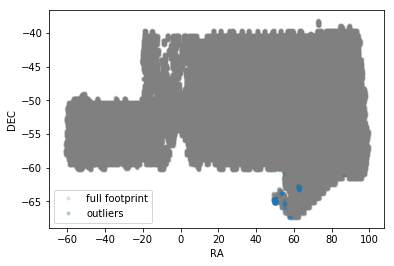

In [420]:
spatialcheck( [sysMap['sys_SLRSFDRES_z_SPT'], sysMap['sys_SLRSFDRES_z_SPT'][~mask]], label = ['full footprint', 'outliers'] )

In [ ]:
fig, ax = plt.subplots()
ax.scatter( sysMap['sys_SLRSFDRES_z_SPT']  )

slope  0.8850564763810687
slope  1.0297011611210465
slope  1.241989412593112
slope  1.274011447129513
slope  1.0690216389530887
slope  1.1616181143821482
slope  1.2446431464110925
slope  1.341097407750811


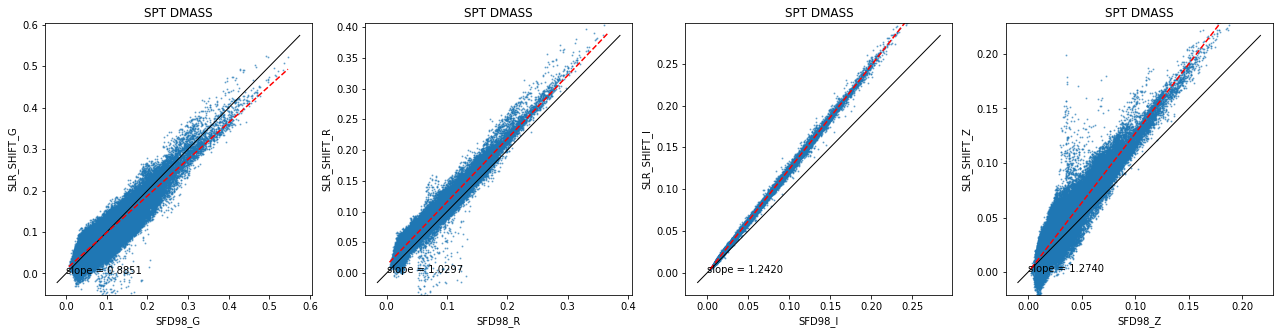

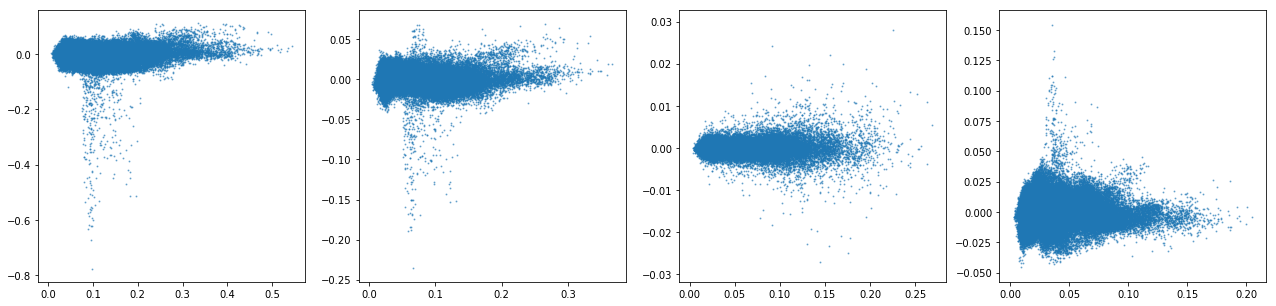

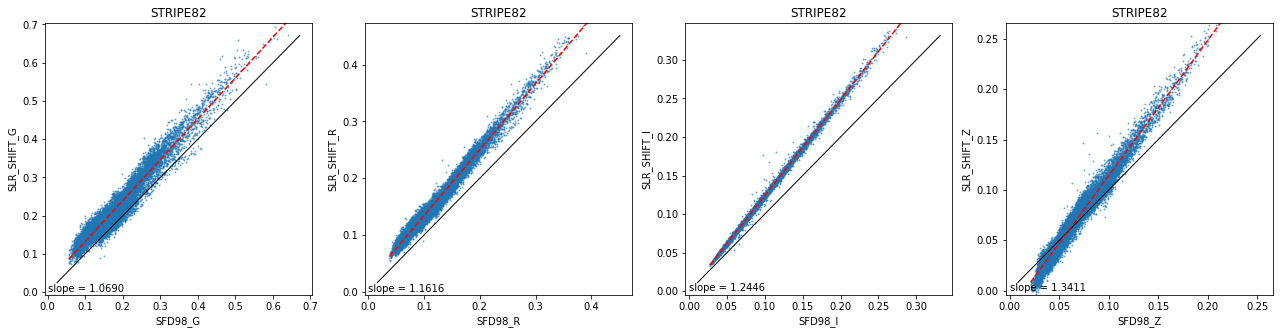

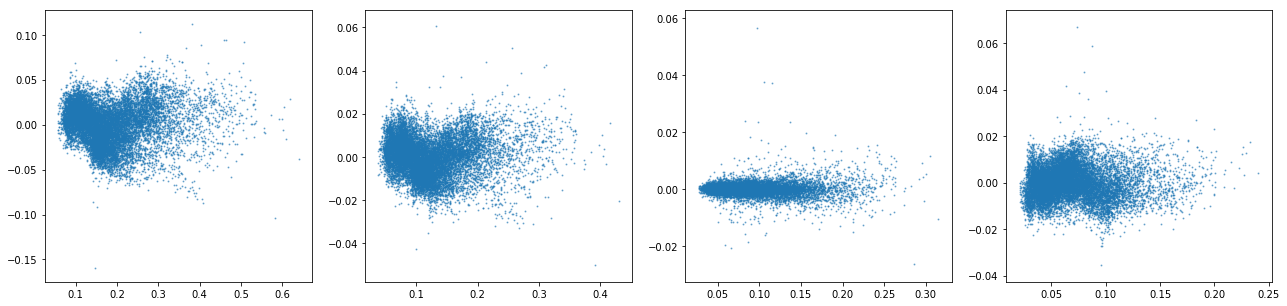

In [438]:
plotting_sfd_slr(None, suffix='SPT DMASS', kind = 'SPT')
#plotting_sfd_slr(dmass_st82_slr, suffix='DMASS_STRIPE82')
plotting_sfd_slr(None, suffix='STRIPE82', kind='STRIPE82')

slope  0.8756995417021903
slope  1.0287104302559769
slope  1.2379202447018622
slope  1.2687058157130573
slope  1.0718924738922828
slope  1.1591230166018152
slope  1.2335844072575277
slope  1.3238351277633011
slope  1.0624814383202372
slope  1.1538262422377759
slope  1.235181401299424
slope  1.3274582563017086


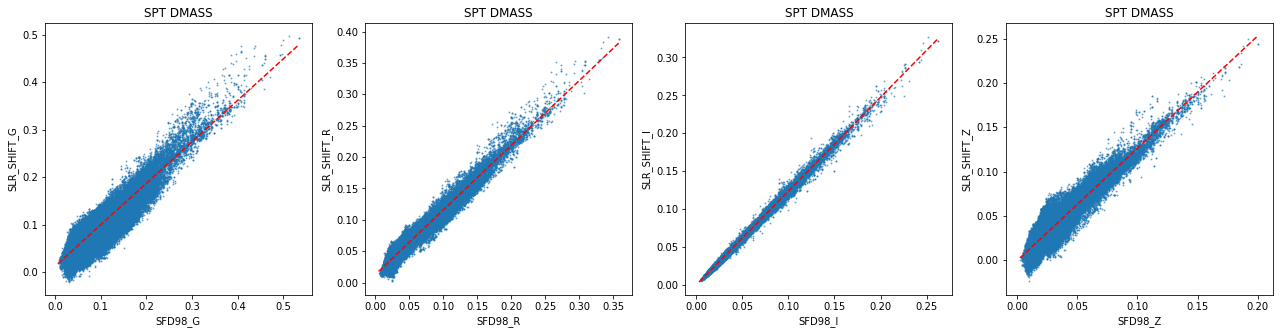

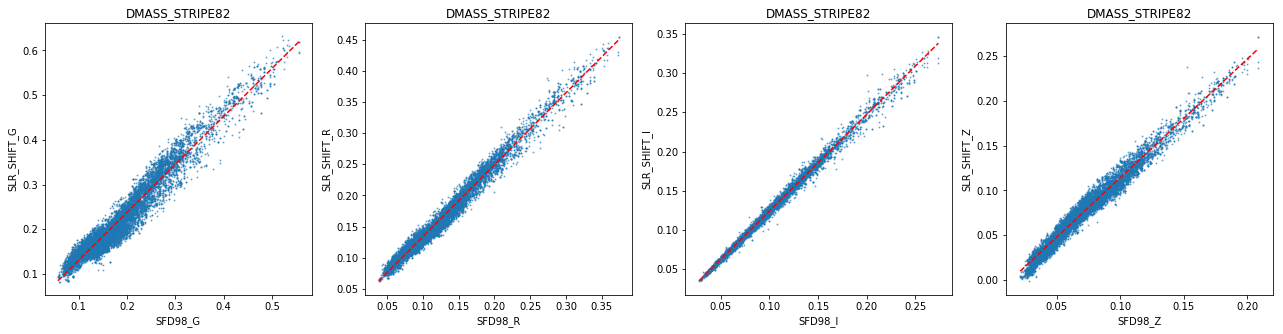

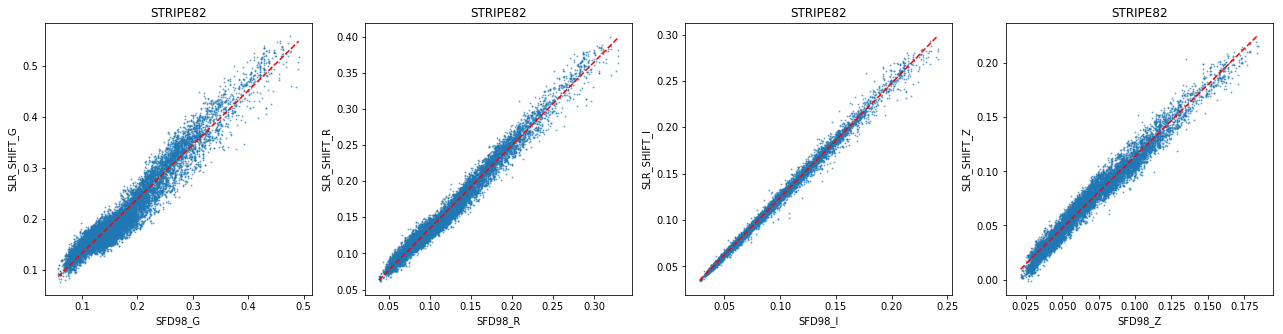

In [542]:
plotting_sfd_slr_gal(dmass_slr, suffix='SPT DMASS')
plotting_sfd_slr_gal(dmass_st82_slr, suffix='DMASS_STRIPE82')
plotting_sfd_slr_gal(cmass_slr, suffix='STRIPE82', kind='STRIPE82 CMASS')

../data_txt/systematics/slr/MAG_MODEL_SFD98_G_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_G_DMASS_SPT_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_R_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_R_DMASS_SPT_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_I_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_I_DMASS_SPT_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_Z_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_Z_DMASS_SPT_RAW.png


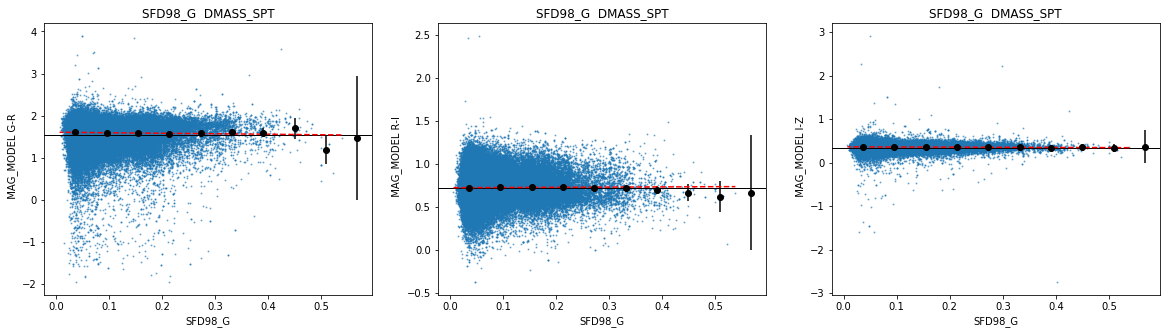

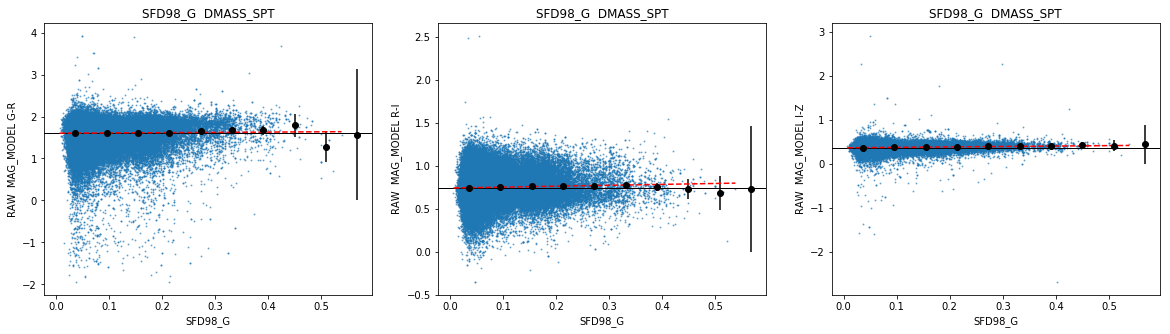

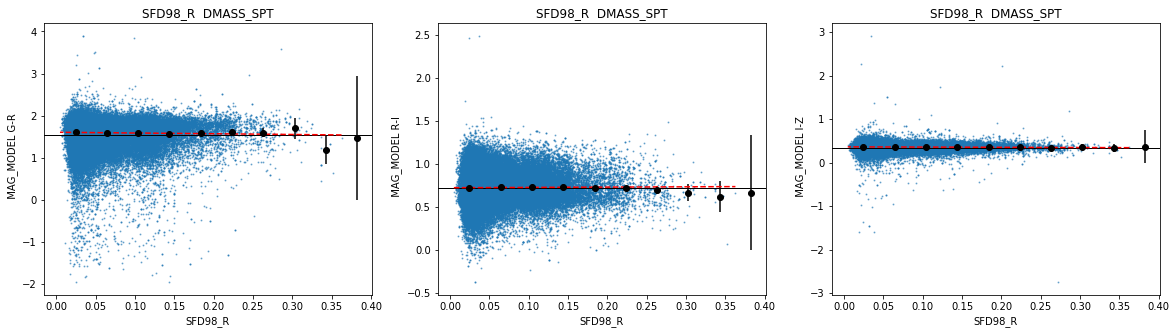

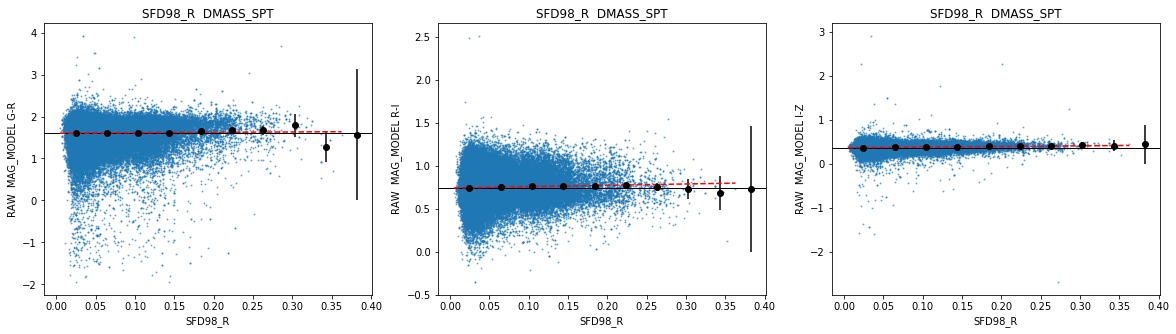

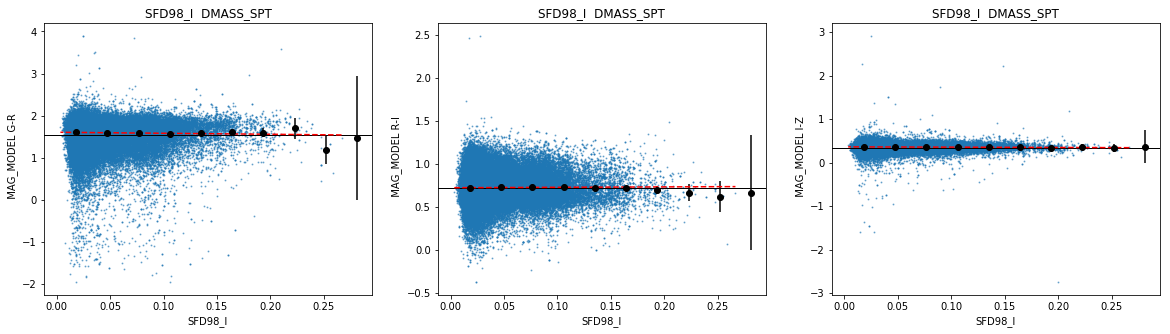

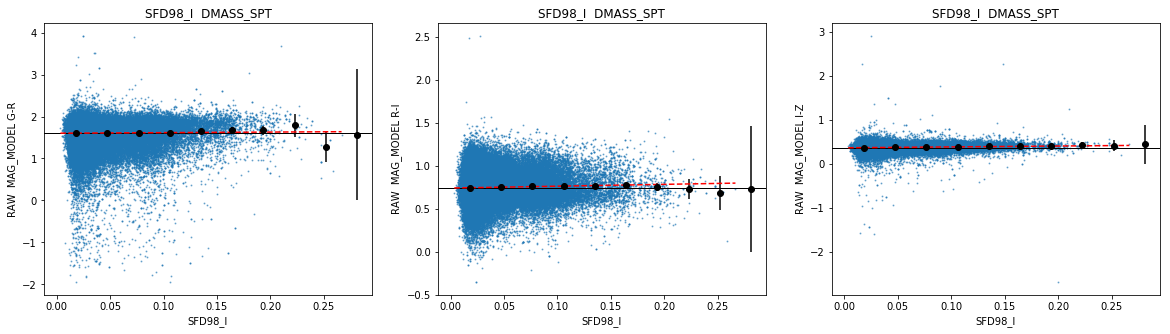

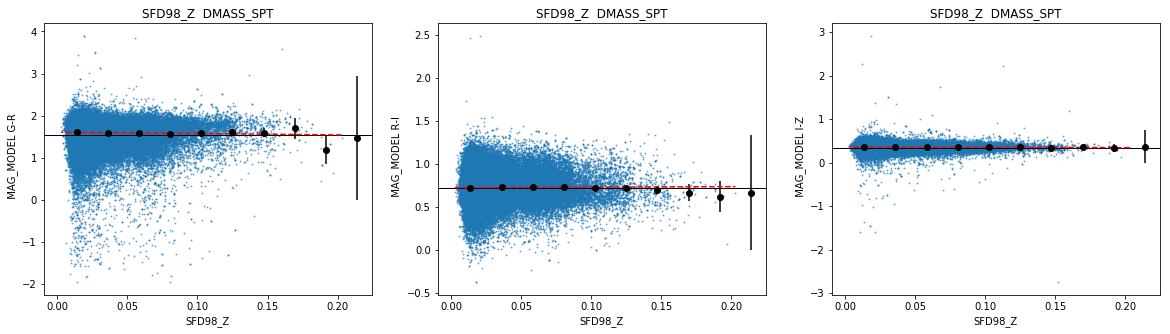

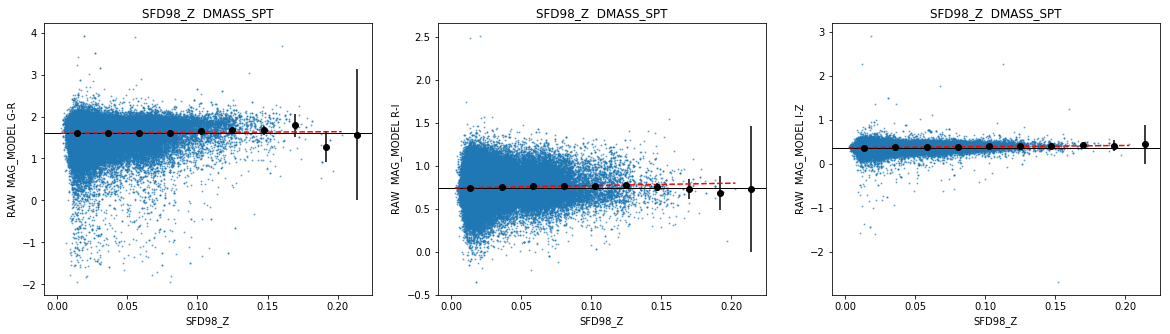

In [179]:
mag = 'MAG_MODEL'
plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=0)
plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=0, rawmag=True)

plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=1)
plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=1, rawmag=True)

plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=2)
plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=2, rawmag=True)

plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=3)
plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=3, rawmag=True)

#plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=1)
#plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=2)
#plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=3)

../data_txt/systematics/slr/MAG_MODEL_SFD98_G_CMASS_STRIPE82_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_G_CMASS_STRIPE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_R_CMASS_STRIPE82_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_R_CMASS_STRIPE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_I_CMASS_STRIPE82_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_I_CMASS_STRIPE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_Z_CMASS_STRIPE82_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_Z_CMASS_STRIPE82_RAW.png


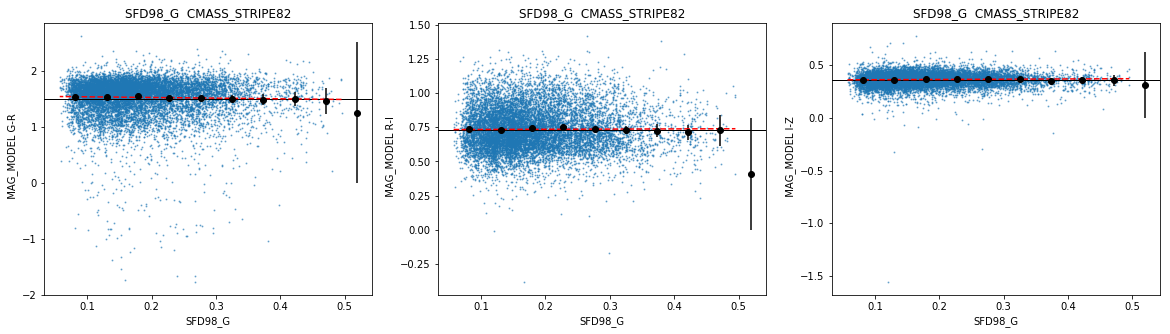

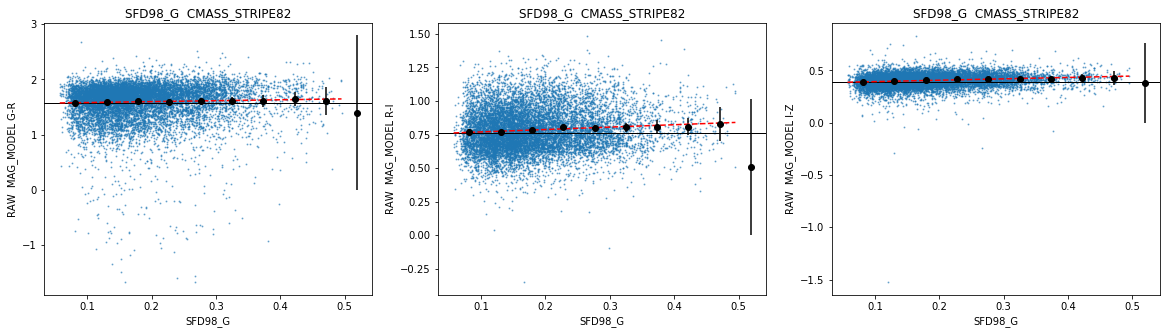

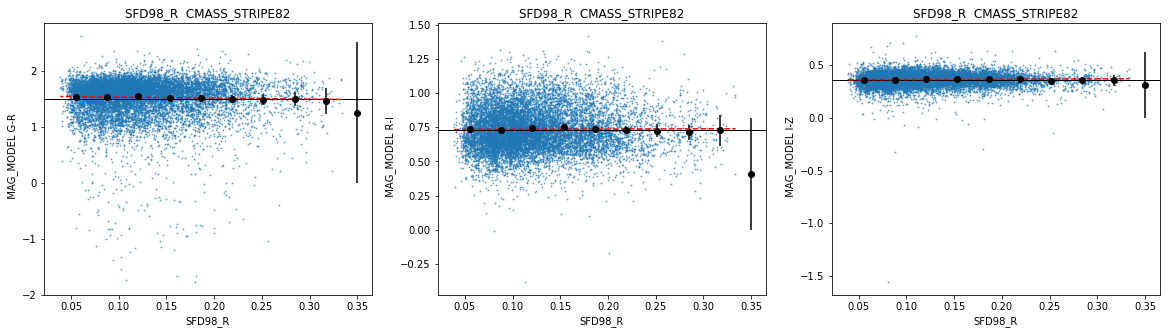

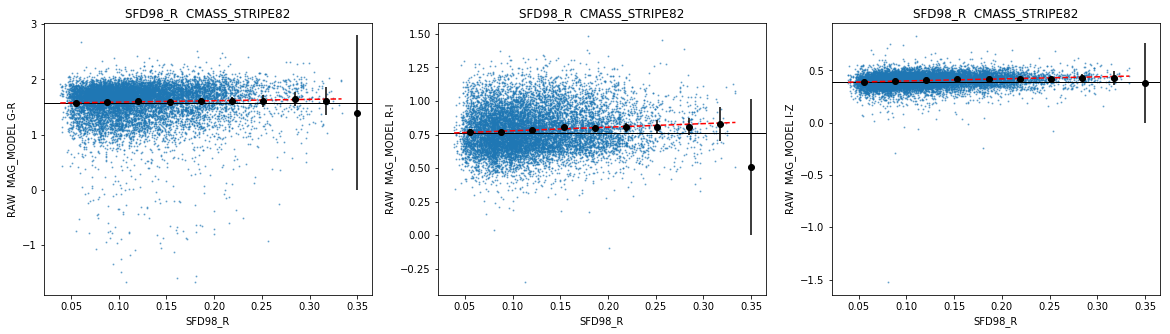

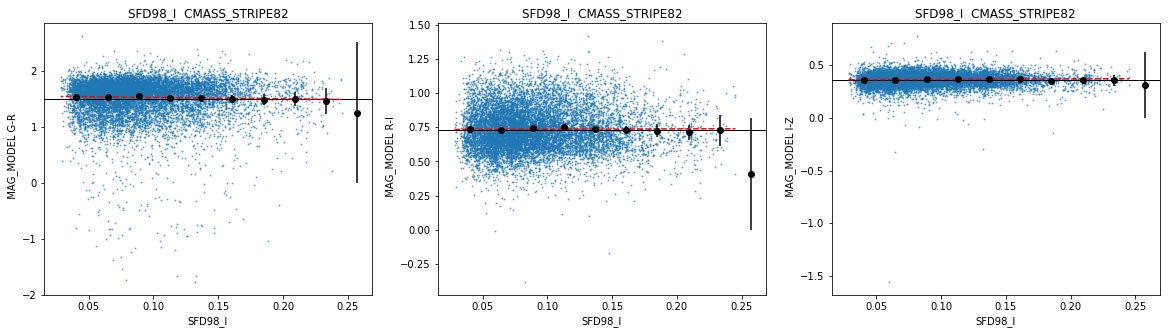

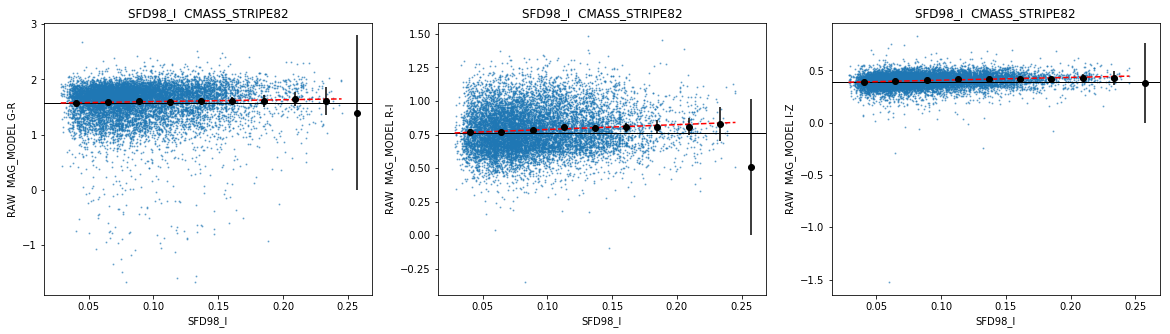

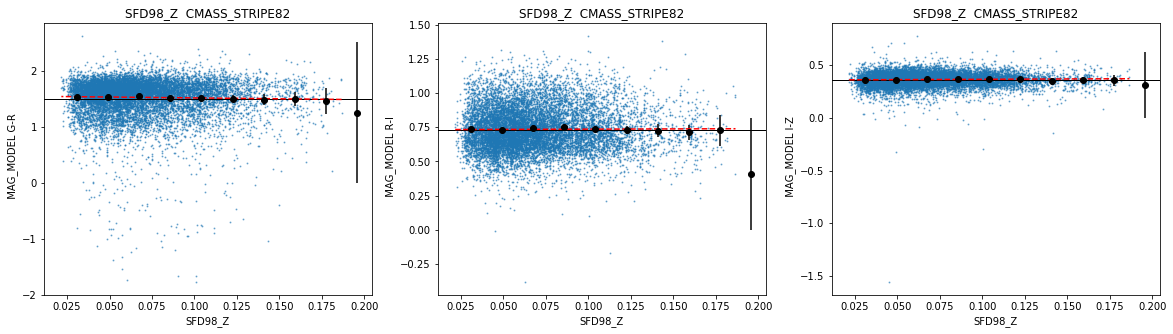

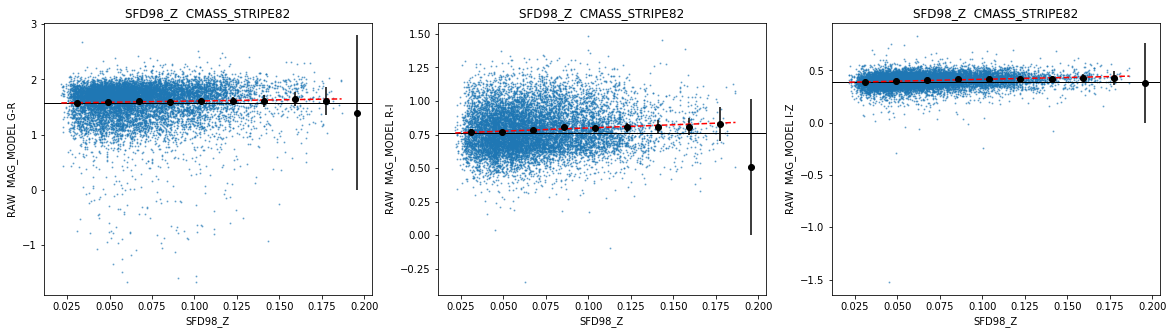

In [180]:
sample = cmass_slr
suffix = 'CMASS_STRIPE82'
plotting_reddening(sample, mag, 'SFD98', suffix = suffix, sfd_band=0)
plotting_reddening(sample, mag, 'SFD98', suffix = suffix, sfd_band=0, rawmag=True)

plotting_reddening(sample, mag, 'SFD98', suffix = suffix, sfd_band=1)
plotting_reddening(sample, mag, 'SFD98', suffix = suffix, sfd_band=1, rawmag=True)

plotting_reddening(sample, mag, 'SFD98', suffix = suffix, sfd_band=2)
plotting_reddening(sample, mag, 'SFD98', suffix = suffix, sfd_band=2, rawmag=True)

plotting_reddening(sample, mag, 'SFD98', suffix = suffix, sfd_band=3)
plotting_reddening(sample, mag, 'SFD98', suffix = suffix, sfd_band=3, rawmag=True)



#plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=1)
#plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=2)
#plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', sfd_band=3)

../data_txt/systematics/slr/MAG_MODEL_SFD98_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_CMASS_STRIPE82_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_DMASS_STRIPE82_.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_DMASS_SPT_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_CMASS_STRIPE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SFD98_DMASS_STRIPE82_RAW.png


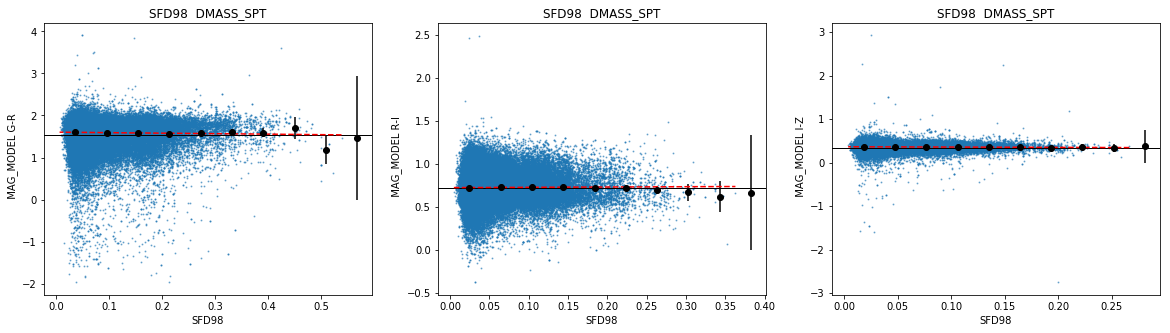

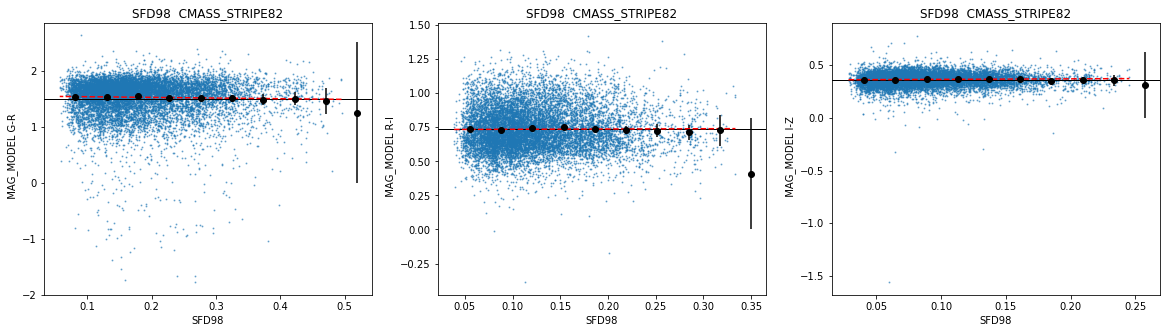

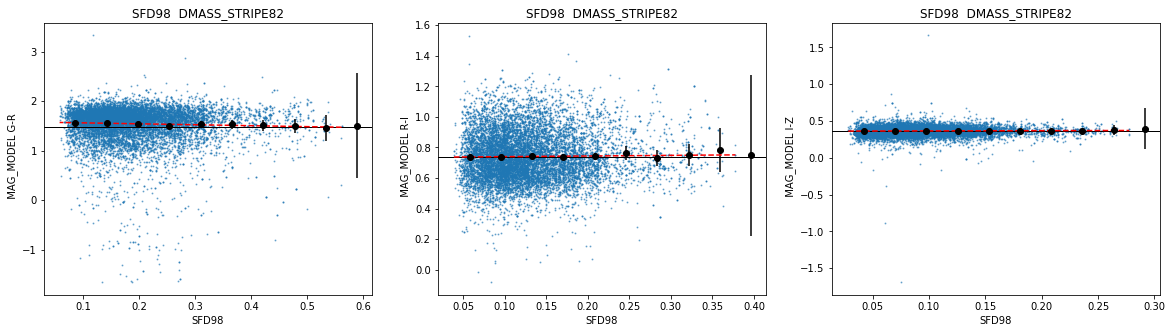

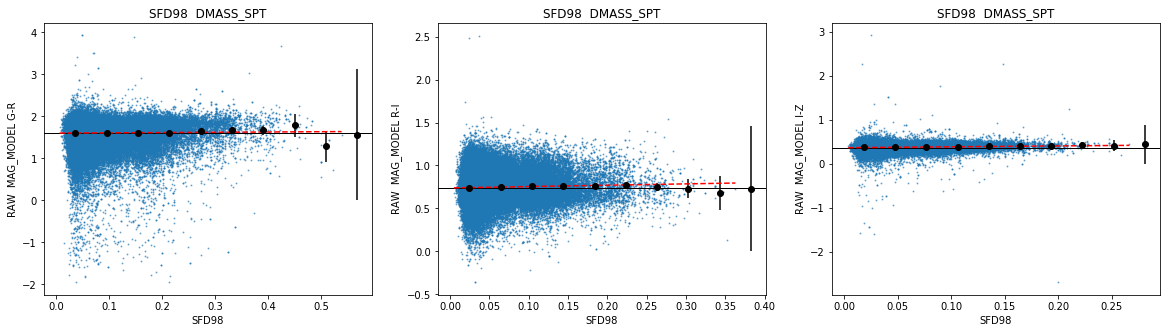

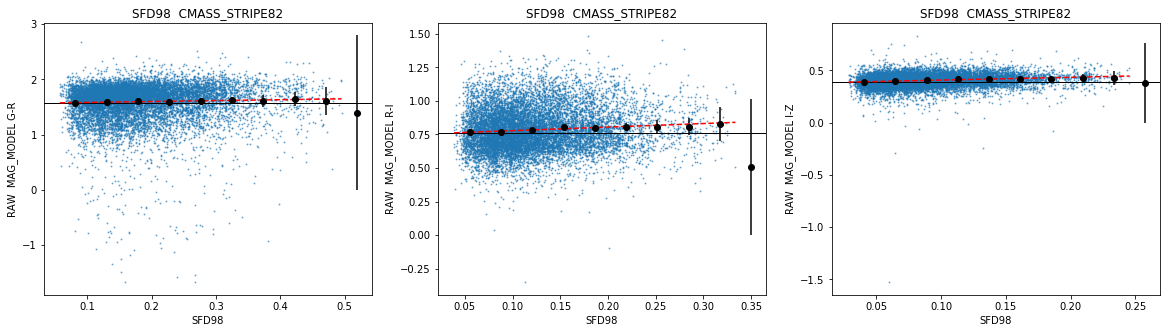

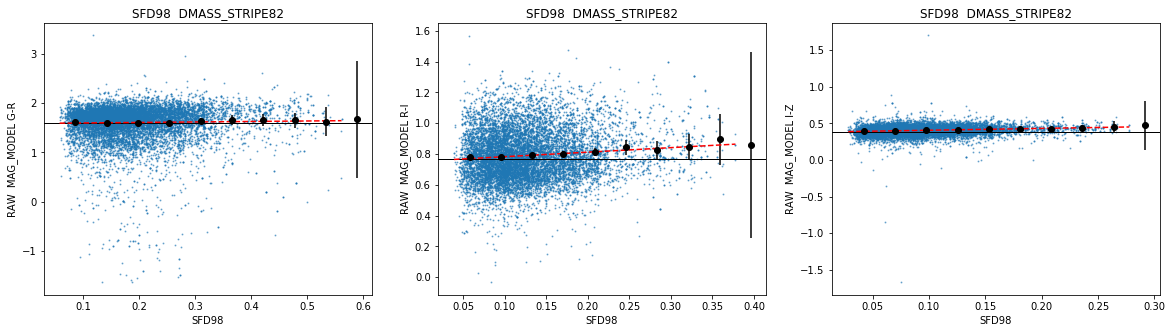

In [104]:
#mag = 'MAG_MODEL'
plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT')
plotting_reddening(cmass_slr, mag, 'SFD98', suffix ='CMASS_STRIPE82')
plotting_reddening(dmass_st82_slr, mag, 'SFD98', suffix ='DMASS_STRIPE82')

plotting_reddening(dmass_slr, mag, 'SFD98', suffix = 'DMASS_SPT', rawmag=True)
plotting_reddening(cmass_slr, mag, 'SFD98', suffix ='CMASS_STRIPE82', rawmag=True)
plotting_reddening(dmass_st82_slr, mag, 'SFD98', suffix ='DMASS_STRIPE82', rawmag=True)

../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_G_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_R_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_I_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_Z_DMASS_SPT_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_G_DMASS_SPT_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_R_DMASS_SPT_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_I_DMASS_SPT_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_Z_DMASS_SPT_RAW.png


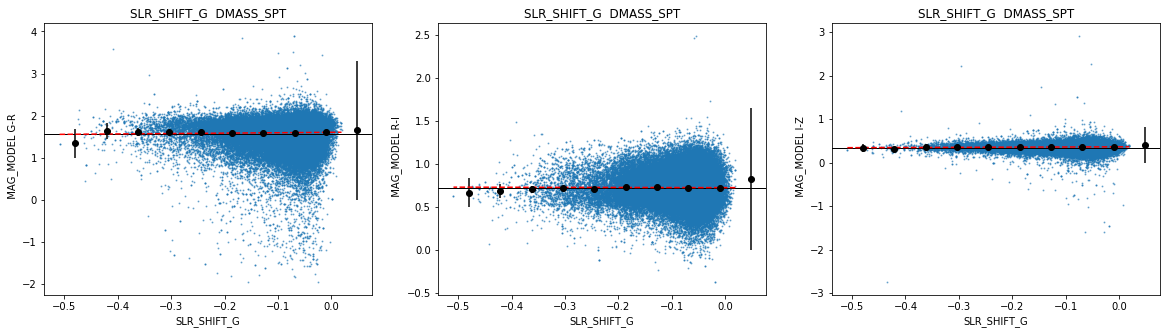

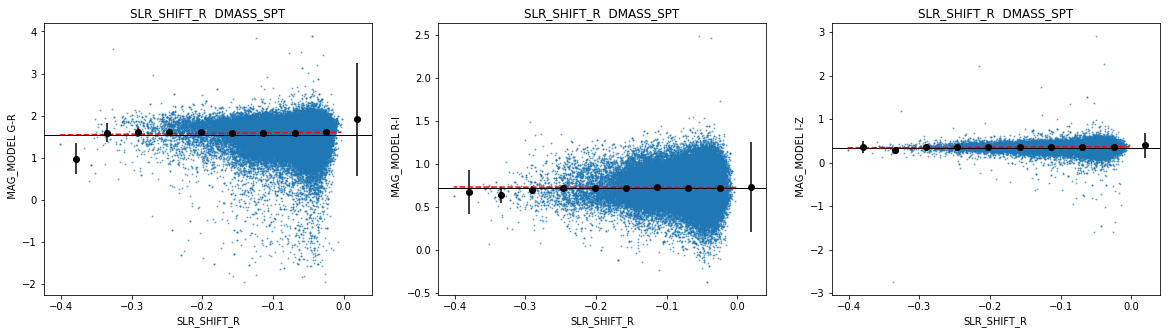

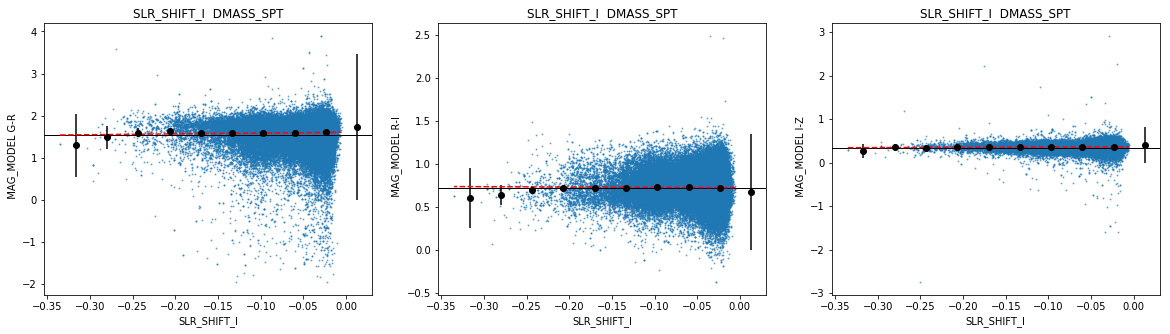

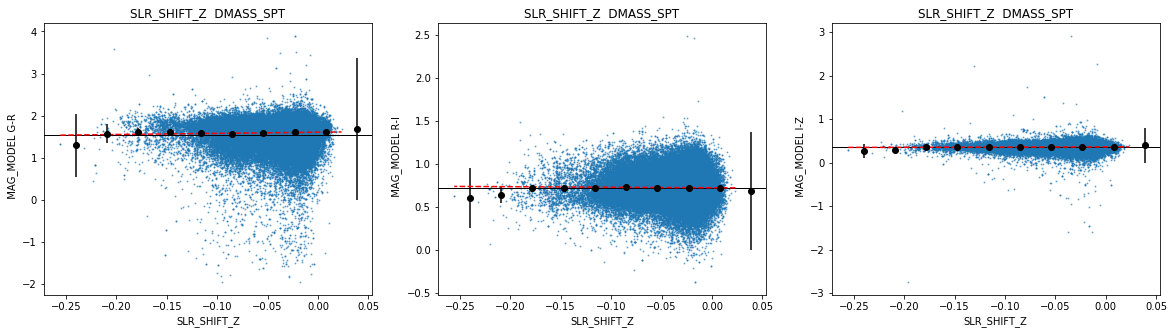

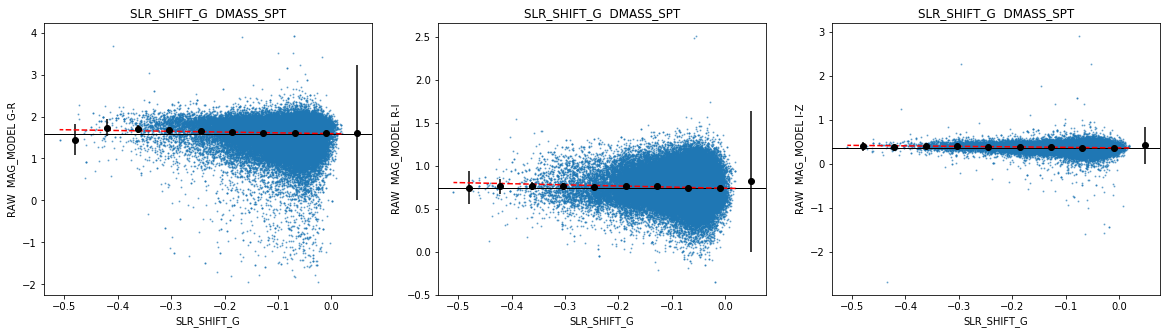

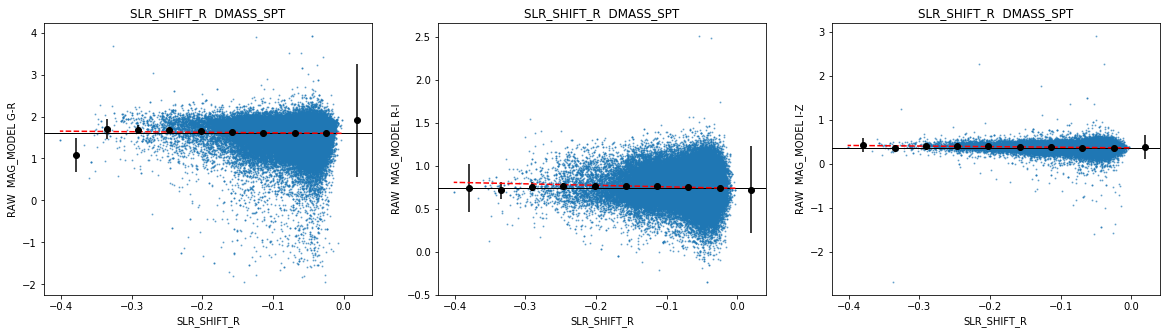

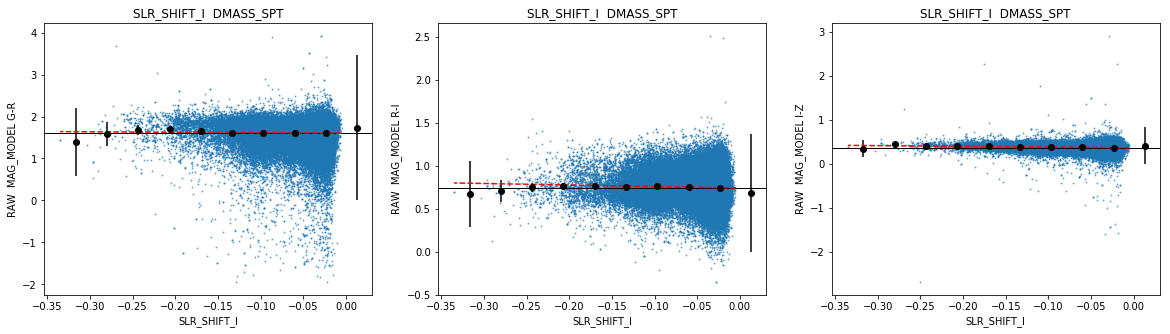

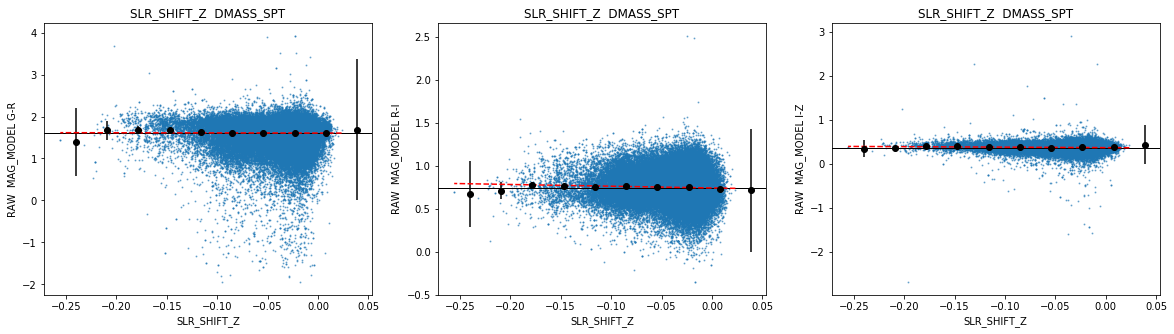

In [105]:
suffix = 'DMASS_SPT'
sample = dmass_slr
plotting_reddening(sample, mag, 'SLR_SHIFT_G', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_R', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_I', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_Z', suffix = suffix)

plotting_reddening(sample, mag, 'SLR_SHIFT_G', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_R', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_I', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_Z', suffix = suffix, rawmag = True)

#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_R')
#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_I')
#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_Z')
#plotting_reddening_slr(dmass_slr, mag, 'SLR_SHIFT')

../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_G_CMASS_STRIE82_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_R_CMASS_STRIE82_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_I_CMASS_STRIE82_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_Z_CMASS_STRIE82_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_G_CMASS_STRIE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_R_CMASS_STRIE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_I_CMASS_STRIE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_Z_CMASS_STRIE82_RAW.png


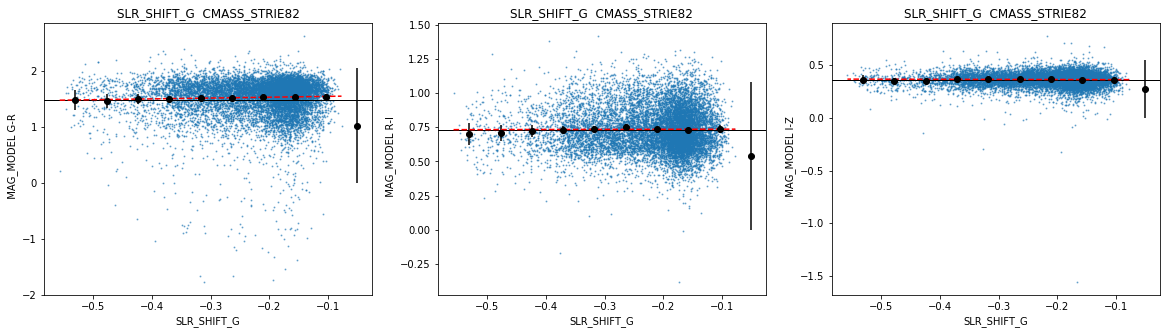

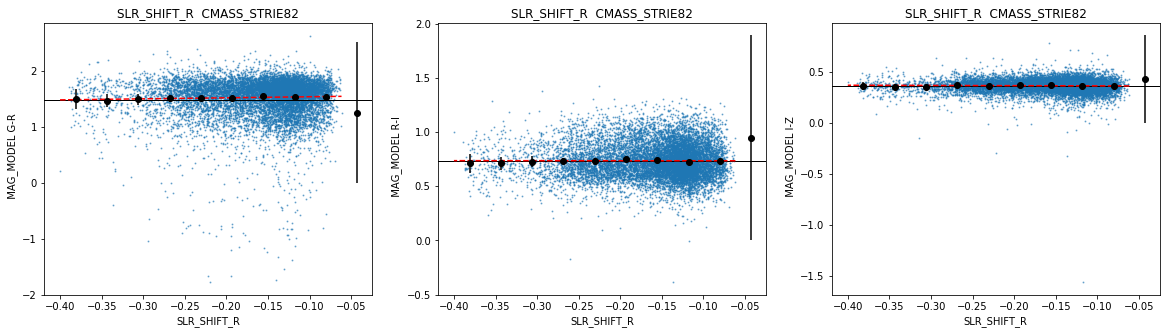

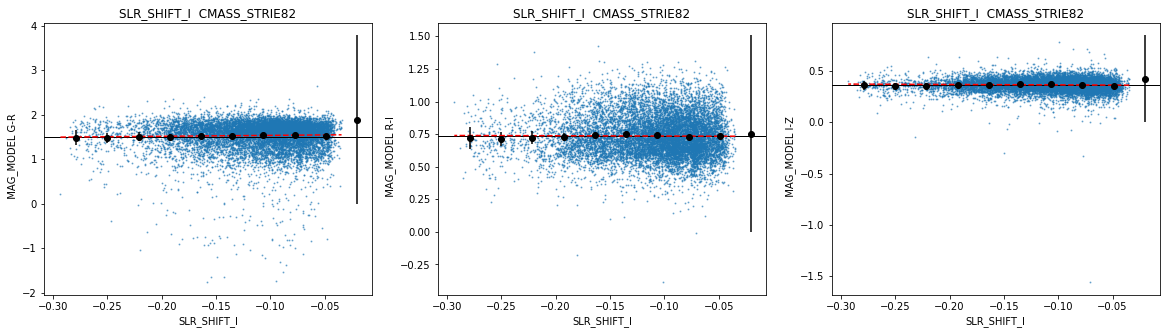

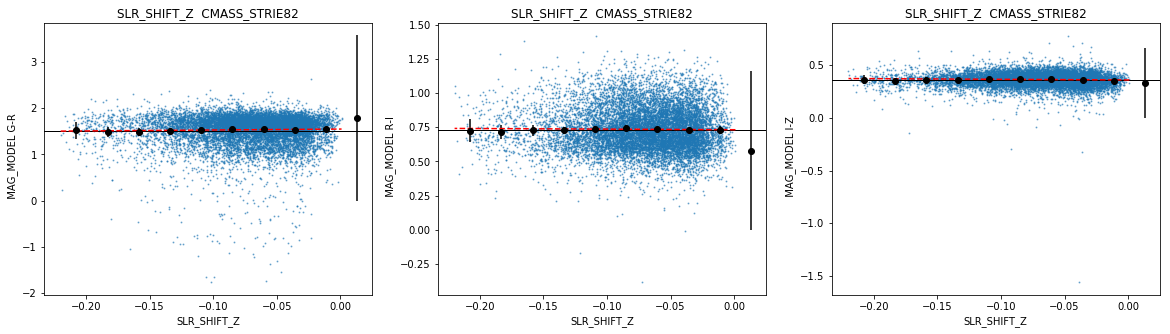

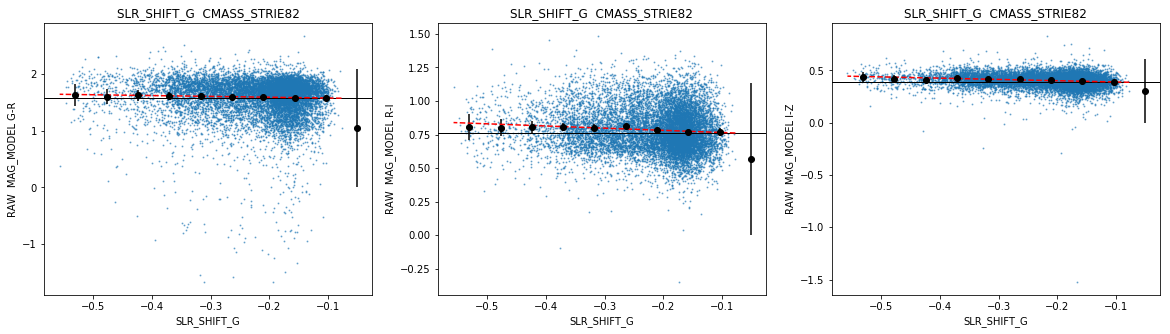

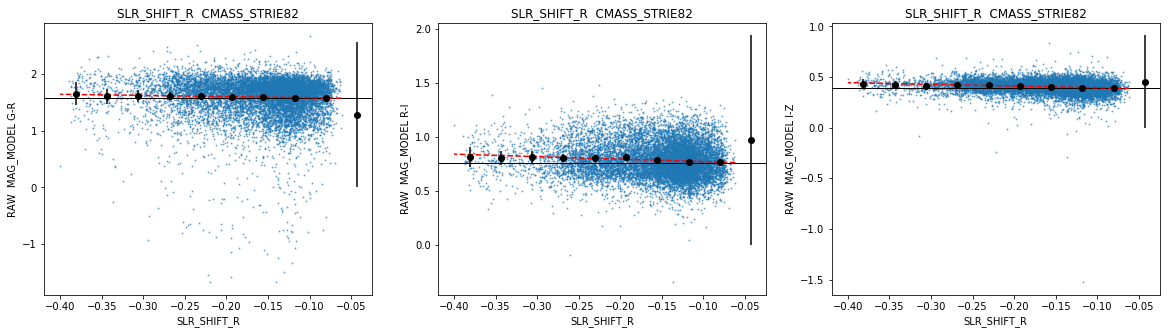

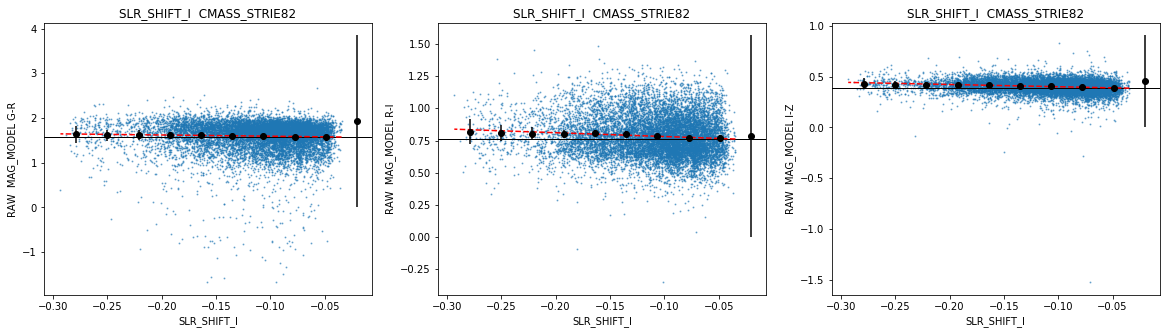

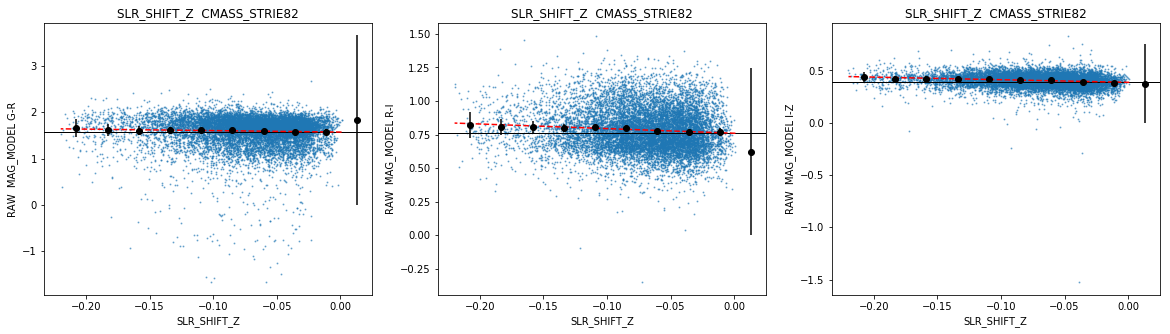

In [106]:
suffix = 'CMASS_STRIE82'
sample = cmass_slr
plotting_reddening(sample, mag, 'SLR_SHIFT_G', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_R', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_I', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_Z', suffix = suffix)

plotting_reddening(sample, mag, 'SLR_SHIFT_G', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_R', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_I', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_Z', suffix = suffix, rawmag = True)

#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_R')
#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_I')
#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_Z')
#plotting_reddening_slr(dmass_slr, mag, 'SLR_SHIFT')

../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_G_DMASS_STRIE82_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_R_DMASS_STRIE82_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_I_DMASS_STRIE82_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_Z_DMASS_STRIE82_.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_G_DMASS_STRIE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_R_DMASS_STRIE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_I_DMASS_STRIE82_RAW.png
../data_txt/systematics/slr/MAG_MODEL_SLR_SHIFT_Z_DMASS_STRIE82_RAW.png


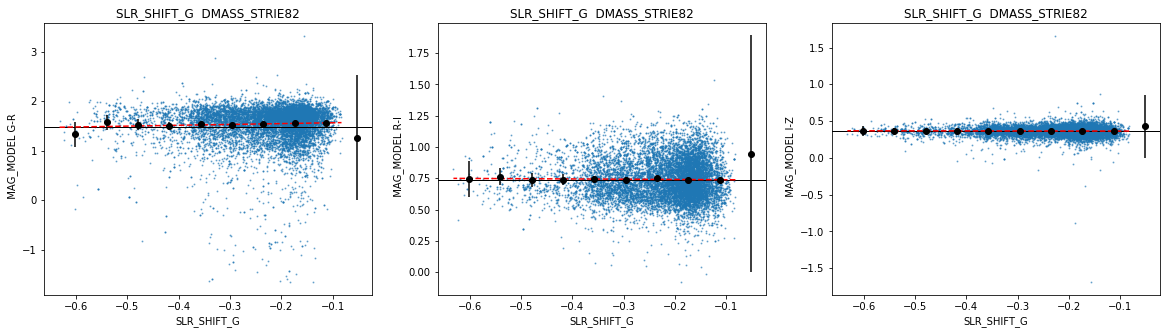

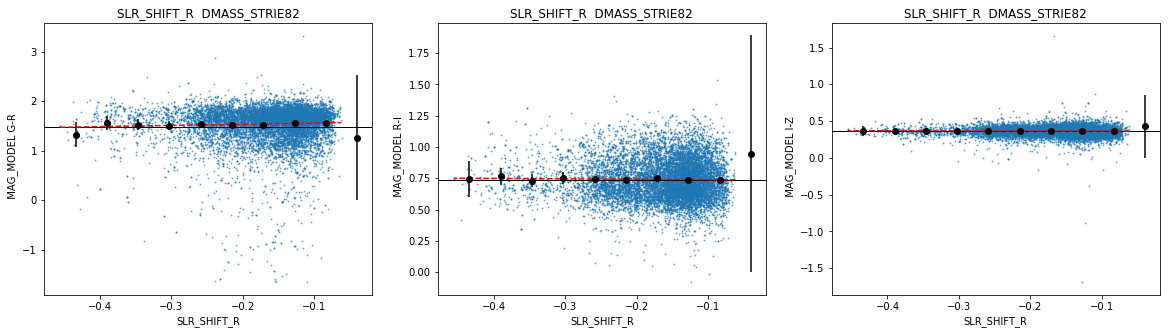

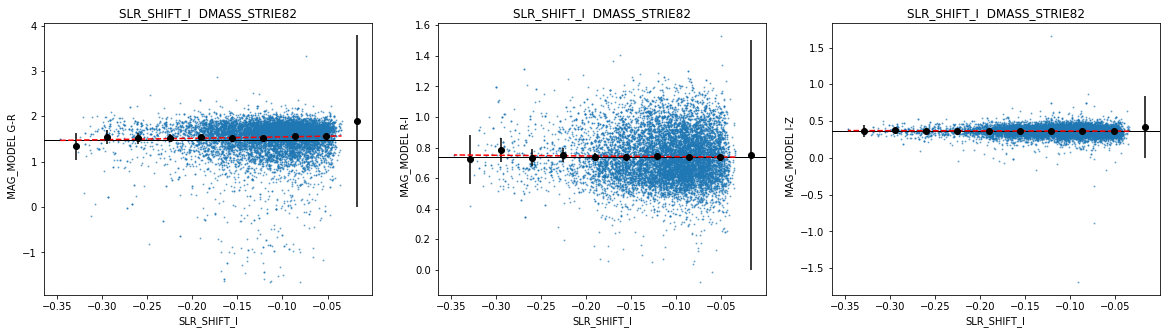

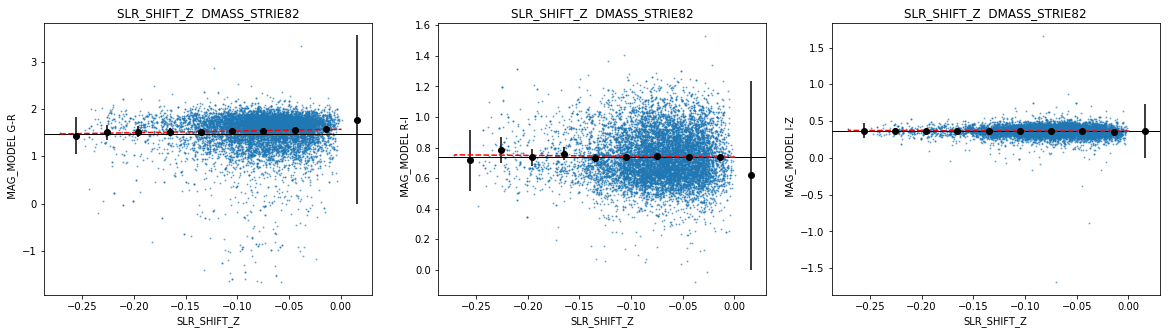

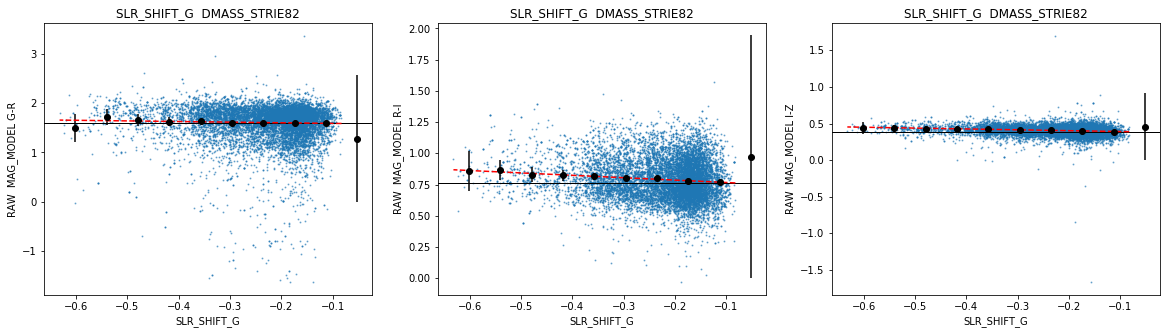

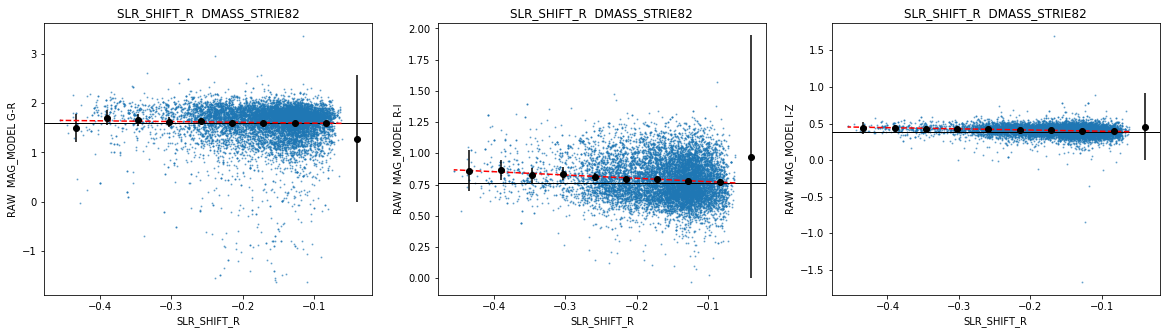

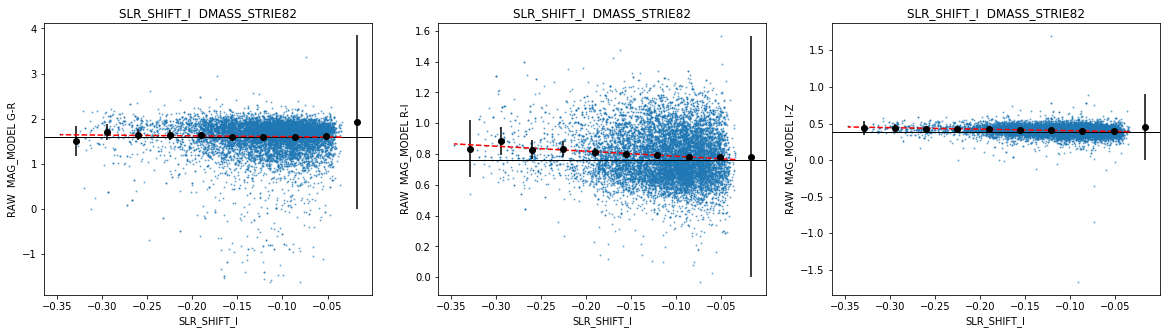

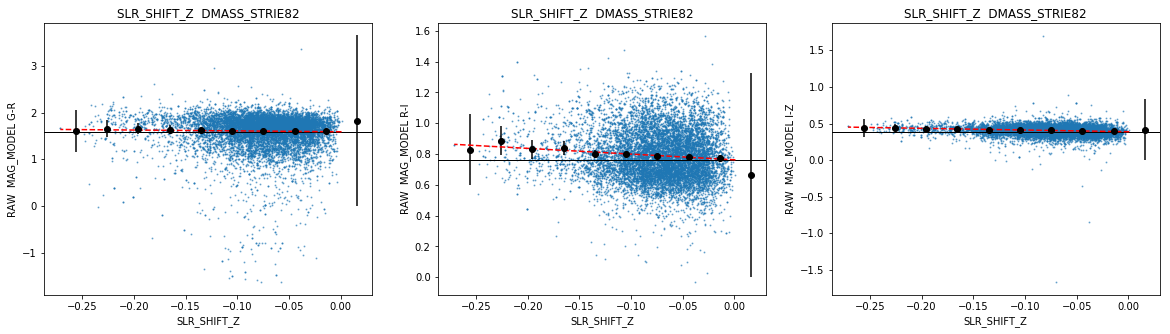

In [107]:
suffix = 'DMASS_STRIE82'
sample = dmass_st82_slr
plotting_reddening(sample, mag, 'SLR_SHIFT_G', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_R', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_I', suffix = suffix)
plotting_reddening(sample, mag, 'SLR_SHIFT_Z', suffix = suffix)

plotting_reddening(sample, mag, 'SLR_SHIFT_G', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_R', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_I', suffix = suffix, rawmag = True)
plotting_reddening(sample, mag, 'SLR_SHIFT_Z', suffix = suffix, rawmag = True)

#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_R')
#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_I')
#plotting_reddening(dmass_slr, mag, 'SLR_SHIFT_Z')
#plotting_reddening_slr(dmass_slr, mag, 'SLR_SHIFT')

# SFD - SLR galaxy number density 

In [202]:
inputdir = '../data_txt/systematics/sfd_slr/'
figoutdir = inputdir+'/figure/'
basedir = inputdir+'/act/'
os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+inputdir+'/weights/')
#os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

0

In [371]:
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['SLRSFDRES'], kind='SPT', nbins =15, 
         reweight= None, nside = 512,
         suffix='no_weight', outdir=inputdir)

saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_g_SPT_no_weight.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_r_SPT_no_weight.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_i_SPT_no_weight.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_z_SPT_no_weight.txt


saving fig to  ../data_txt/systematics/sfd_slr//figure/systematic_SLRSFDRES_SPT_no_weight.png


0

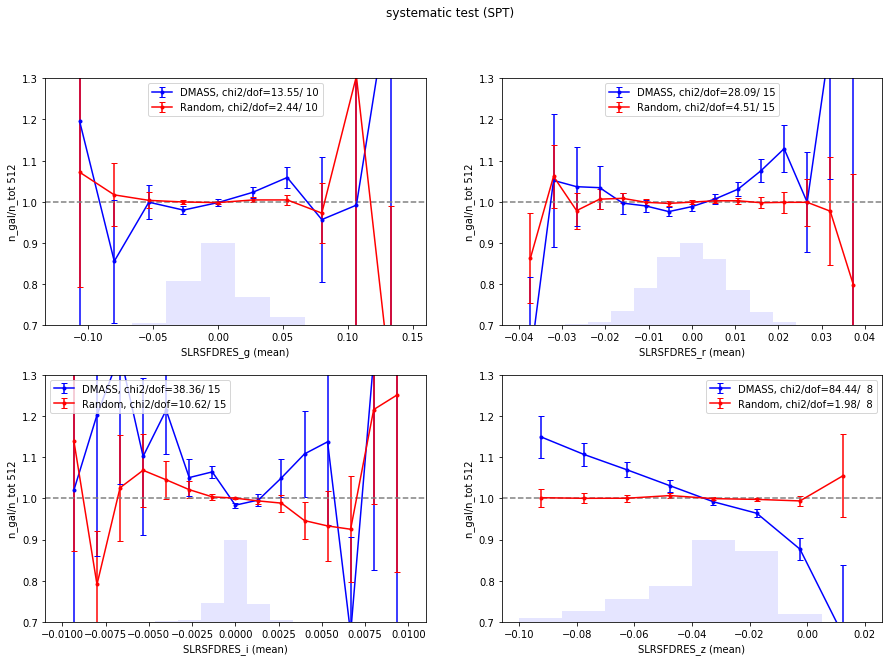

In [372]:
from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'SLRSFDRES', nside = 512, kind = 'SPT', suffix='no_weight', \
                     inputdir=inputdir, outdir=figoutdir)

In [ ]:
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['SLRSFDRES'], kind='SPT', nbins =15, 
         reweight= None, nside = 512,
         suffix='no_weight', outdir=inputdir)

In [385]:
sys_ngal(cat1 = cmass, cat2=rand_cmass, rand1 = rand2_cmass, rand2 = rand2_cmass, sysmap = sysMap_st82, 
         FullArea = ST82Maparea, properties = ['SLRSFDRES'], kind='STRIPE82', nbins =15, 
         reweight= None, nside = 512,
         suffix='train', outdir=inputdir)

saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_g_STRIPE82_train.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_r_STRIPE82_train.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_i_STRIPE82_train.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_z_STRIPE82_train.txt


saving fig to  ../data_txt/systematics/sfd_slr//figure/systematic_SLRSFDRES_STRIPE82_train.png


0

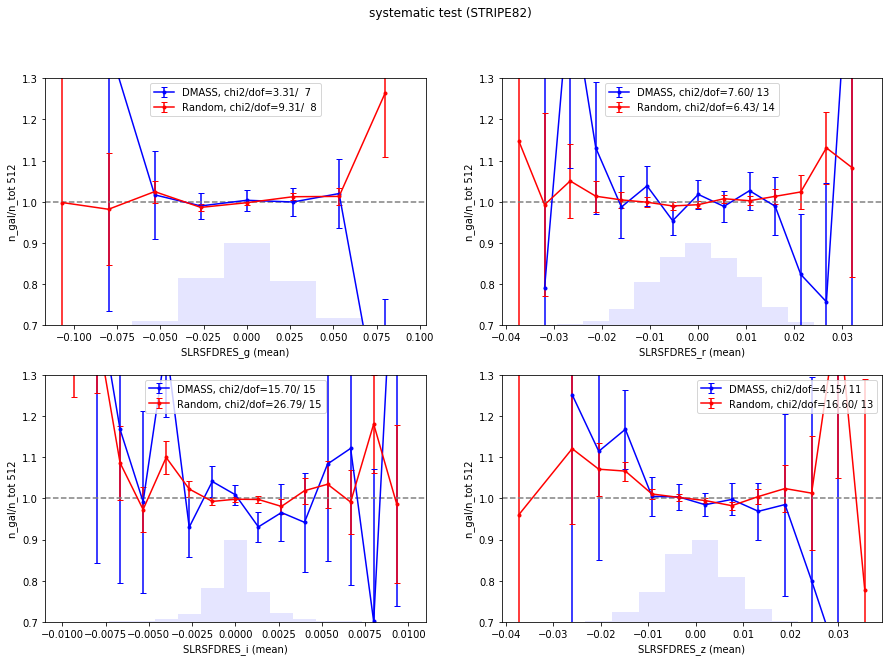

In [386]:
doVisualization_ngal(property = 'SLRSFDRES', nside = 512, kind = 'STRIPE82', suffix='train', \
                     inputdir=inputdir, outdir=figoutdir)

saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_g_STRIPE82_dmass_st82.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_r_STRIPE82_dmass_st82.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_i_STRIPE82_dmass_st82.txt
saving data to  ../data_txt/systematics/sfd_slr/systematic_SLRSFDRES_z_STRIPE82_dmass_st82.txt
saving fig to  ../data_txt/systematics/sfd_slr//figure/systematic_SLRSFDRES_STRIPE82_dmass_st82.png


0

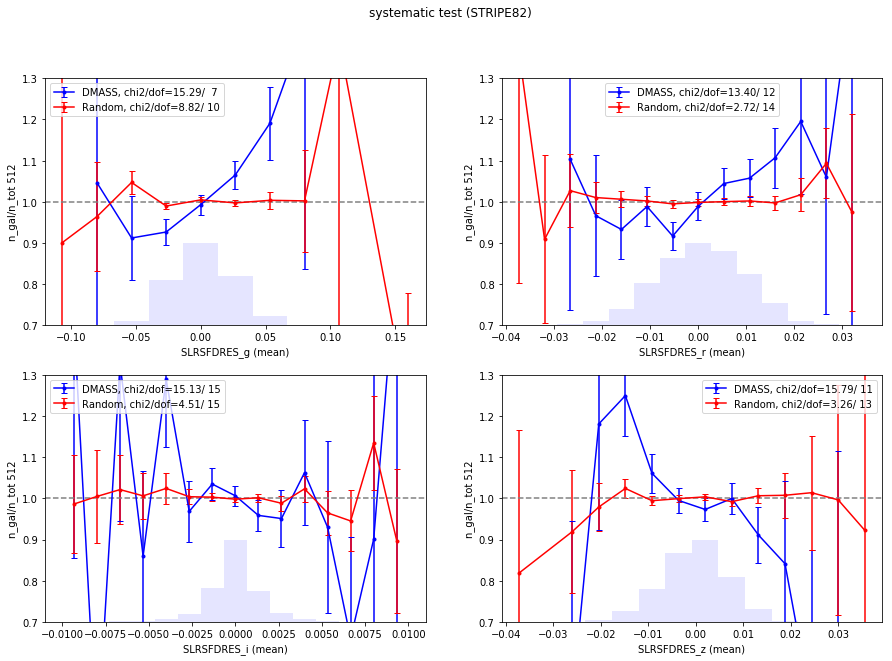

In [387]:
sys_ngal(cat1 = dmass_st82, cat2=rand_dmass_st82, rand1 = rand2_dmass_st82, rand2 = rand2_dmass_st82, sysmap = sysMap_st82, 
         FullArea = ST82Maparea, properties = ['SLRSFDRES'], kind='STRIPE82', nbins =15, 
         reweight= None, nside = 512,
         suffix='dmass_st82', outdir=inputdir)
from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'SLRSFDRES', nside = 512, kind = 'STRIPE82', suffix='dmass_st82', \
                     inputdir=inputdir, outdir=figoutdir)


In [483]:
sysMap_st82_ge = calling_sysMap( properties=['GE'], kind='STRIPE82', nside=4096 )

../systematics.py:484: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand
../systematics.py:488: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:488: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/sfd_slr/systematic_GE_g_STRIPE82_dmass_sfd_st82.txt
saving fig to  ../data_txt/systematics/sfd_slr//figure/systematic_GE_STRIPE82_dmass_sfd_st82.png


0

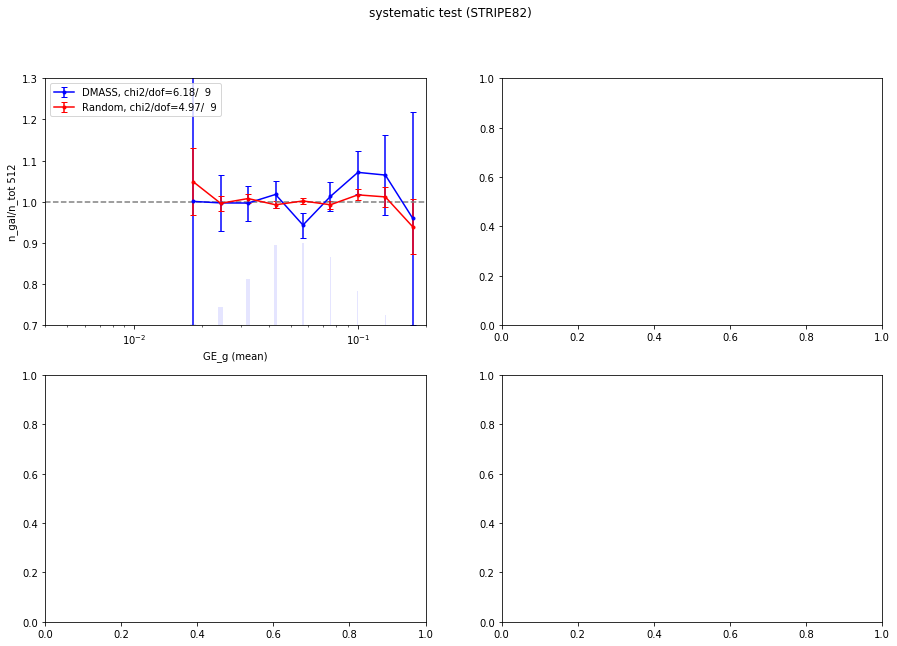

In [486]:
sys_ngal(cat1 = dmass_sfd_st82, cat2=rand_dmass_st82, rand1 = rand2_dmass_st82, rand2 = rand2_dmass_st82, 
         sysmap = sysMap_st82_ge, 
         FullArea = ST82Maparea, properties = ['GE'], kind='STRIPE82', nbins =15, 
         reweight= None, nside = 512,
         suffix='dmass_sfd_st82', outdir=inputdir)

from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 512, kind = 'STRIPE82', suffix='dmass_sfd_st82', \
                     inputdir=inputdir, outdir=figoutdir)



saving fig to  ../data_txt/systematics/ge_low//figure/systematic_GE_SPT_no_weight.png


0

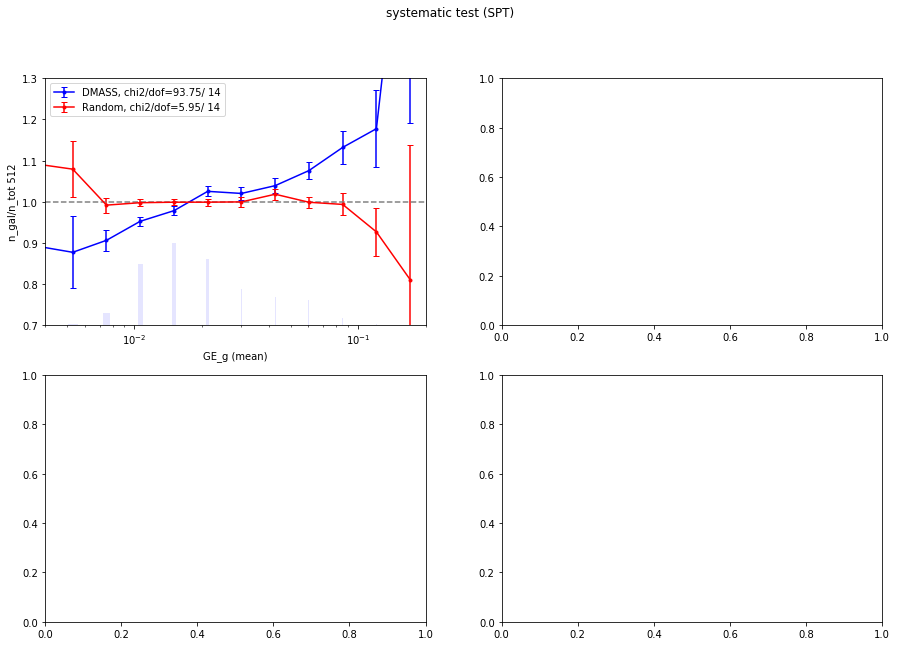

In [772]:
from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 4096, kind = kind, suffix='no_weight', \
                     inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/ge_low//figure/systematic_GE_SPT_no_weight.png


0

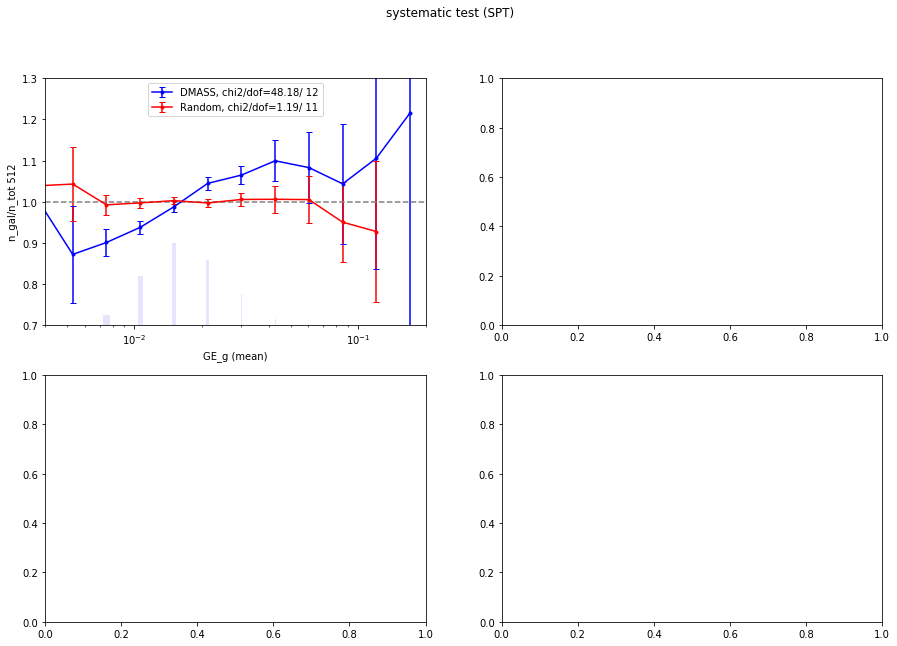

In [770]:
from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 4096, kind = kind, suffix='no_weight', \
                     inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/ge_low//figure/systematic_GE_STRIPE82_train.png
saving fig to  ../data_txt/systematics/ge_low//figure/systematic_GE_STRIPE82_dmass_st82.png


0

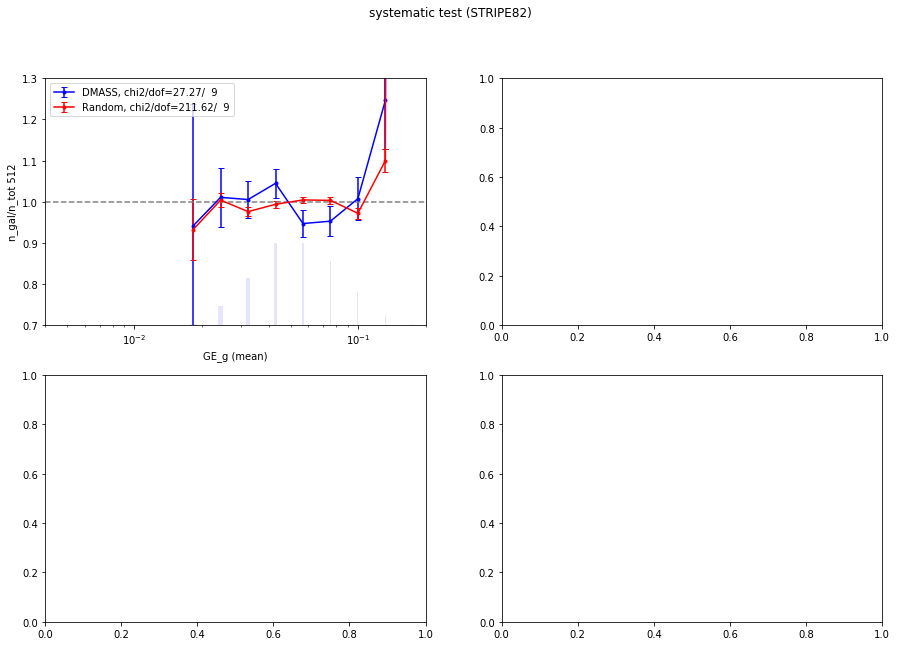

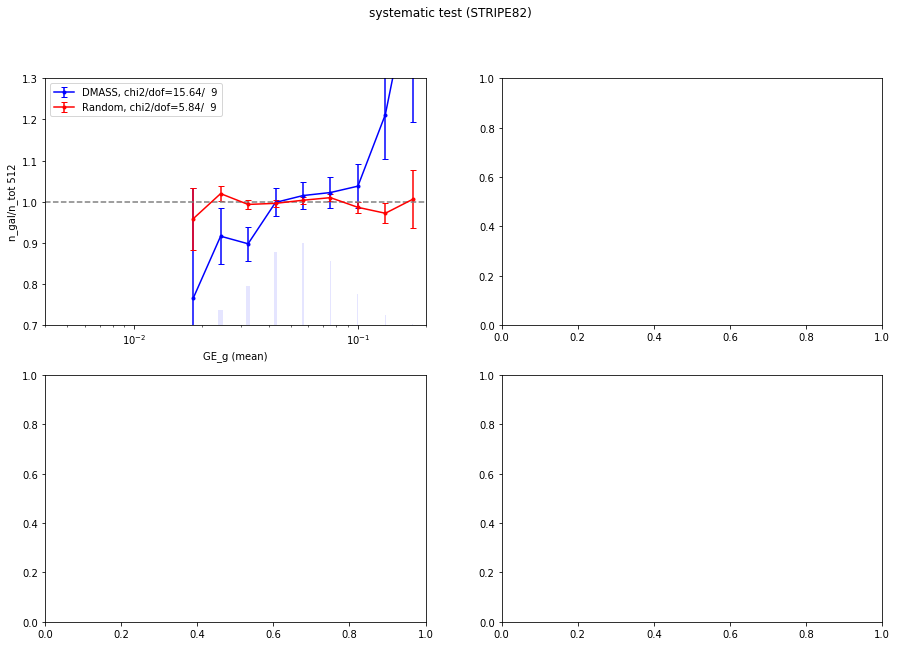

In [665]:
from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 4096, kind = 'STRIPE82', suffix='train', \
                     inputdir=inputdir, outdir=figoutdir)
from systematics_module.contCorrection import doVisualization_ngal
doVisualization_ngal(property = 'GE', nside = 4096, kind = 'STRIPE82', suffix='dmass_st82', \
                     inputdir=inputdir, outdir=figoutdir)

# SLR 

In [875]:
sys_ngal(cat1 = dmass_st82, cat2=rand_dmass_st82, rand1 = rand2_dmass_st82, rand2 = rand2_dmass_st82, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['SLR'], kind='SPT', nbins =20, 
         reweight= None, nside = 512,
         suffix='dmass_st82', outdir=inputdir)

saving data to  ../data_txt/systematics/ge_low/systematic_SLR_g_SPT_dmass_st82.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_r_SPT_dmass_st82.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_i_SPT_dmass_st82.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_z_SPT_dmass_st82.txt


In [876]:
sys_ngal(cat1 = cmass, cat2=rand_cmass, rand1 = rand2_cmass, rand2 = rand2_cmass, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['SLR'], kind='SPT', nbins =20, 
         reweight= None, nside = 512,
         suffix='st82', outdir=inputdir)

saving data to  ../data_txt/systematics/ge_low/systematic_SLR_g_SPT_st82.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_r_SPT_st82.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_i_SPT_st82.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_z_SPT_st82.txt


In [877]:
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['SLR'], kind='SPT', nbins =20, 
         reweight= None, nside = 512,
         suffix='no_weight', outdir=inputdir)

saving data to  ../data_txt/systematics/ge_low/systematic_SLR_g_SPT_no_weight.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_r_SPT_no_weight.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_i_SPT_no_weight.txt
saving data to  ../data_txt/systematics/ge_low/systematic_SLR_z_SPT_no_weight.txt


saving fig to  ../data_txt/systematics/ge_low//figure/systematic_SLR_SPT_no_weight.png


0

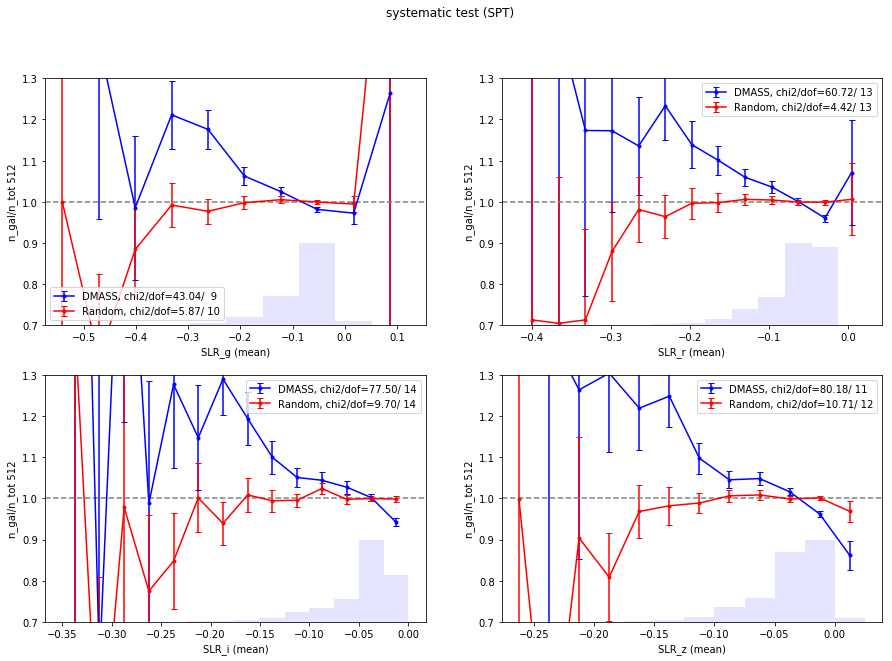

In [878]:
doVisualization_ngal(property = 'SLR', nside = 512, kind = 'SPT', suffix='no_weight', \
                     inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/ge_low//figure/systematic_SLR_SPT_st82.png


0

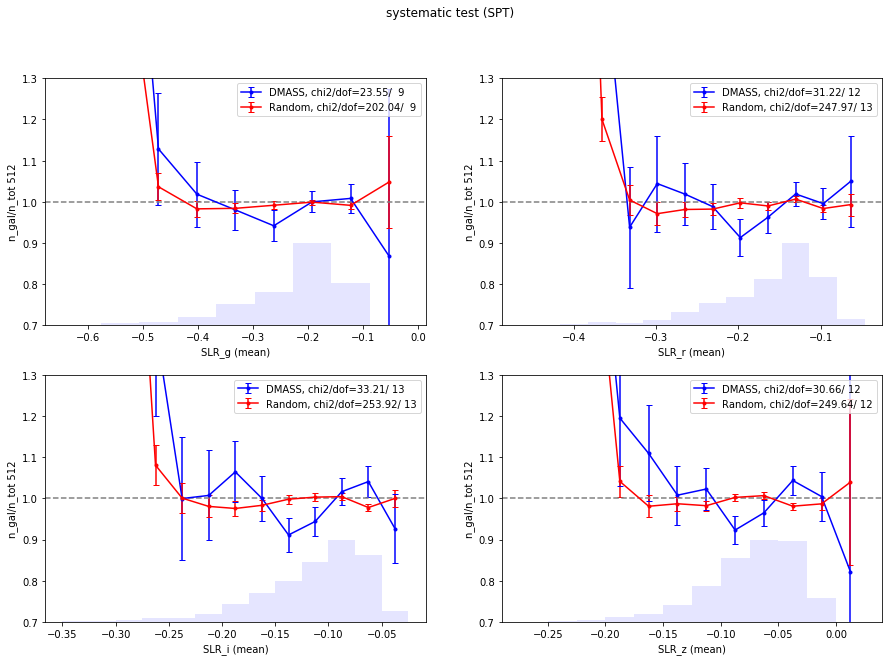

In [879]:
doVisualization_ngal(property = 'SLR', nside = 512, kind = 'SPT', suffix='st82', \
                     inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/ge_low//figure/systematic_SLR_SPT_dmass_st82.png


0

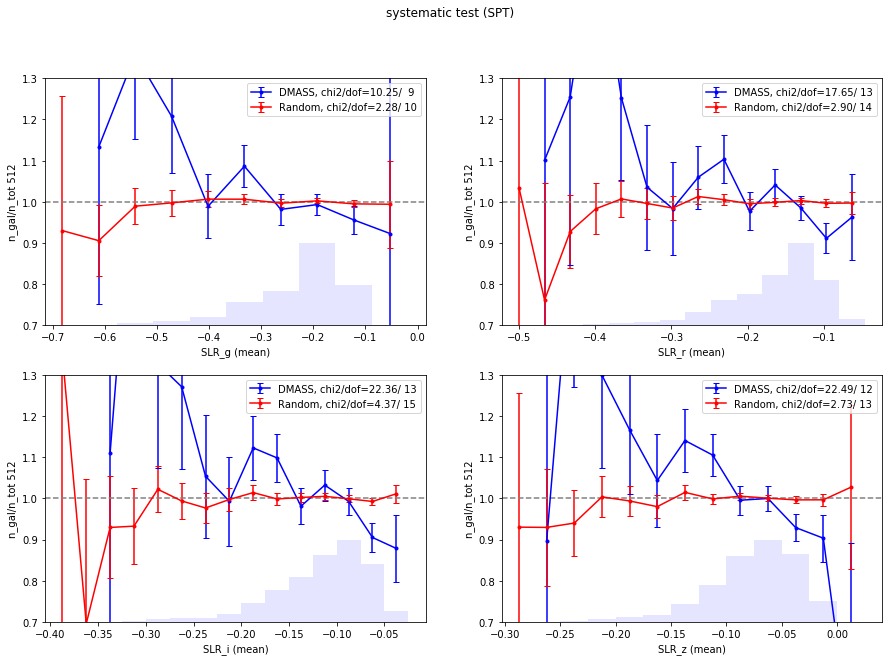

In [880]:
doVisualization_ngal(property = 'SLR', nside = 512, kind = 'SPT', suffix='dmass_st82', \
                     inputdir=inputdir, outdir=figoutdir)

# Splitting ge low and high 

In [741]:
ge_high = ( sysMap['sys_GE_g_SPT']['SIGNAL'] > 0.04 ) & ( sysMap['sys_GE_g_SPT']['SIGNAL'] < 10.0 )
ge_low = sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.0115
hpix_high = sysMap['sys_GE_g_SPT']['PIXEL'][ge_high]
hpix_low = sysMap['sys_GE_g_SPT']['PIXEL'][ge_low]

In [742]:
hpind_dmass = hpRaDecToHEALPixel(dmass['RA'], dmass['DEC'], nside=  512, nest= False)
dmass_gehigh_mask = np.in1d( hpind_dmass, hpix_high )
dmass_gehigh = dmass[dmass_gehigh_mask]
dmass_gelow_mask = np.in1d( hpind_dmass, hpix_low )
dmass_gelow = dmass[dmass_gelow_mask]

print dmass.size, dmass_gehigh.size, dmass_gelow.size

112401 18830 19495


In [743]:
hpind_rand = hpRaDecToHEALPixel(rand2['RA'], rand2['DEC'], nside=  512, nest= False)
rand_gehigh_mask = np.in1d( hpind_rand, hpix_high )
rand_gehigh = rand2[rand_gehigh_mask]
rand_gelow_mask = np.in1d( hpind_rand, hpix_low )
rand_gelow = rand2[rand_gelow_mask]

print rand_gehigh.size, rand_gelow.size

175249 211040


In [744]:
def histogram_ge( sample, sysMap, kind='SPT' ):
    
    hpind_dmass = hpRaDecToHEALPixel(sample['RA'], sample['DEC'], nside=  512, nest= False)
    gebins = np.logspace(np.log10(0.001), np.log10(1), 50)
    inds = np.digitize(sysMap['sys_GE_g_'+kind]['SIGNAL'], gebins)

    Ngals = np.zeros(len(gebins))
    for i in range(len(gebins)) : 
        hpix_i = sysMap['sys_GE_g_'+kind]['PIXEL'][inds == i]
        mask = np.in1d( hpind_dmass, hpix_i )
        Ngals[i] = np.sum(mask)
    return gebins, Ngals * 1./Ngals.max()

In [745]:
deccut = (dmass['RA'] < 75.0)# &(dmass['RA'] >20)
deccut2 = (dmass['RA'] < 75.0) &(dmass['RA'] >20)

In [746]:
gebins, Ngals_dmass = histogram_ge( dmass, sysMap )
gebins, Ngals_dmass2 = histogram_ge( dmass[deccut2], sysMap )
#gebins, Ngals_dmass_gehigh = histogram_ge( dmass_gehigh, sysMap )
#gebins, Ngals_dmass_gelow = histogram_ge( dmass_gelow, sysMap )
gebins, Ngals_cmass = histogram_ge( cmass, sysMap_st82, kind = 'STRIPE82' )
gebins, Ngals_dmass_st82 = histogram_ge( dmass_st82, sysMap_st82, kind = 'STRIPE82' )

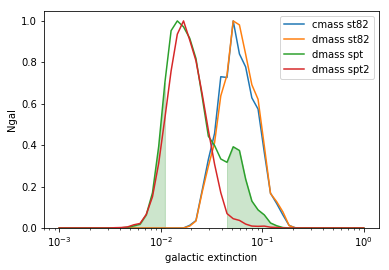

In [747]:
fig, ax = plt.subplots()
ax.plot( gebins, Ngals_cmass, label = 'cmass st82' )
ax.plot( gebins, Ngals_dmass_st82, label = 'dmass st82' )
ax.plot( gebins, Ngals_dmass, label = 'dmass spt' )
ax.plot( gebins, Ngals_dmass2, label = 'dmass spt2' )

ax.fill_between(gebins, 0, Ngals_dmass, where = gebins < 0.012, color = 'green', alpha = 0.2)
ax.fill_between(gebins, 0, Ngals_dmass, where = gebins > 0.04, color = 'green', alpha = 0.2)

ax.set_xscale('log')
ax.set_xlabel('galactic extinction')
ax.set_ylabel('Ngal')
ax.legend()
ax.set_ylim(0,)
fig.savefig(figoutdir+'dist_ge.png')

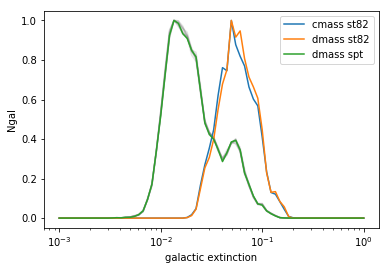

In [595]:
fig, ax = plt.subplots()

for jj in range(10):
    dmass_mocks = fitsio.read('../output/mock/dmass_spt_{:04}.fits'.format(jj+1))
    gebins, Ngals_dmass_mock = histogram_ge( dmass_mocks, sysMap )
    ax.plot( gebins, Ngals_dmass_mock, color = 'grey', alpha = 0.2 )

ax.plot( gebins, Ngals_cmass, label = 'cmass st82' )
ax.plot( gebins, Ngals_dmass_st82, label = 'dmass st82' )
ax.plot( gebins, Ngals_dmass, label = 'dmass spt' )


ax.set_xscale('log')
ax.set_xlabel('galactic extinction')
ax.set_ylabel('Ngal')
ax.legend()
fig.savefig(figoutdir+'dist_ge.png')

# spatial distribution

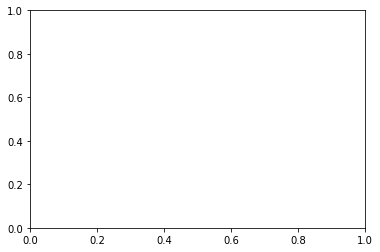

In [619]:
sysMap_st82_cut = Cuts.keepGoodRegion(sysMap_st82['sys_GE_g_STRIPE82'])

figsave : .//spatialtest_.png


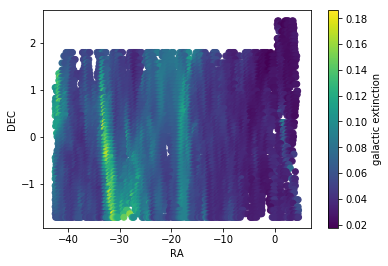

In [639]:
spatialcheck([sysMap_st82_cut], zaxis = sysMap_st82_cut['SIGNAL'], zlabel='galactic extinction' )

figsave : .//spatialtest_.png


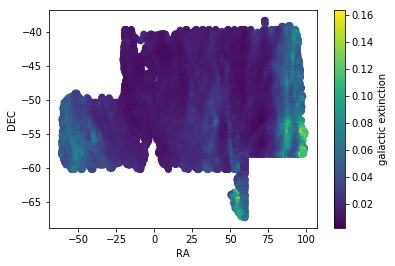

In [640]:
sysMap_cut = Cuts.keepGoodRegion(sysMap['sys_GE_g_SPT'])
spatialcheck([sysMap_cut], zaxis = sysMap_cut['SIGNAL'], zlabel='galactic extinction' )

figsave : .//spatialtest_.png


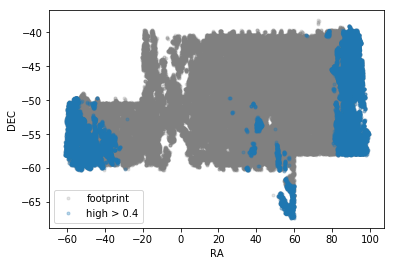

In [749]:
spatialcheck([dmass, dmass_gehigh], label=['footprint', 'high > 0.4', 'low'] )

# Compare photo z distribution

saving fig to  ../data_txt/systematics/ge_low//figure/hist_z_.png


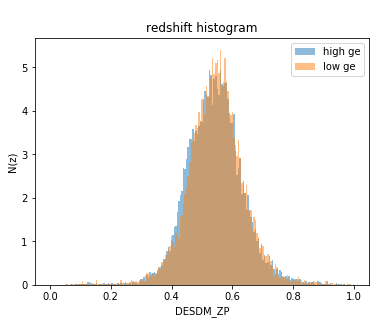

In [492]:
doVisualization_z( cats = [dmass_gehigh, dmass_gelow], 
                  labels = ['high ge', 'low ge'], suffix = '', 
                  zlabel = 'DESDM_ZP', outdir=figoutdir)


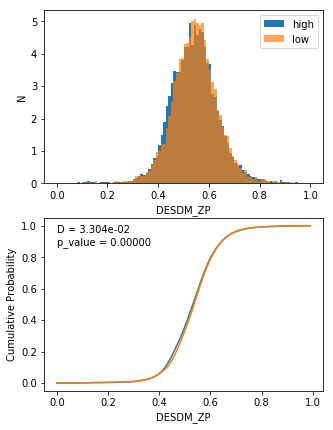

In [511]:
ks_test( dmass_gehigh['DESDM_ZP'], dmass_gelow['DESDM_ZP'], label=['high', 'low'], tag = 'DESDM_ZP', 
        bins=np.linspace(0.0, 1.0, 101), outdir = figoutdir)

# Compare color distribution 

writing output plot to: ../data_txt/systematics/ge_low//figure//diagnostic_histograms_1d.png


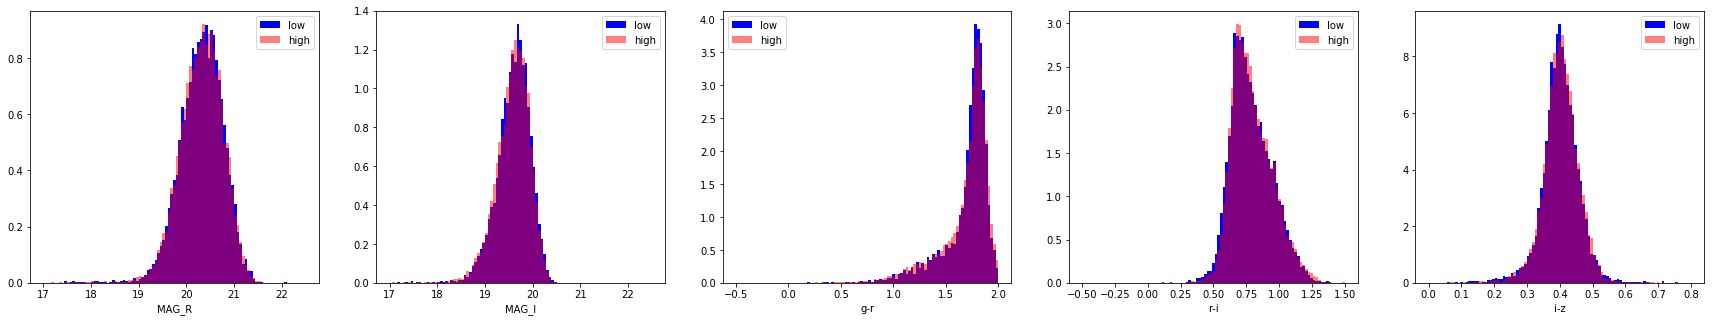

In [313]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]

X_train, Xcov_train = mixing_color(dmass_gehigh, suffix ='')
X_test,_ = mixing_color(dmass_gelow, suffix = '')
   
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                     name =['high','low' ], nbins=100, prefix='', outdir=figoutdir)

# Membership Prob

0

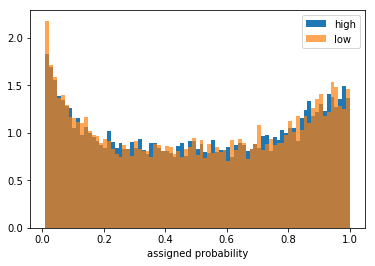

In [512]:
fig, ax = plt.subplots()
pbins = np.linspace(0.01, 1, 80)
ax.hist( dmass_gehigh['EachProb_CMASS'], bins = pbins, normed = 1, label='high' )
ax.hist( dmass_gelow['EachProb_CMASS'], bins = pbins, normed = 1 , alpha = 0.7, label='low')
ax.set_xlabel('assigned probability')
ax.legend()

fig.savefig(figoutdir + 'prob_distribution.png')
0

# Compare dperp color distribution

In [408]:
dperp_high = dmass_gehigh['MAG_DETMODEL_R']- dmass_gehigh['MAG_DETMODEL_I']\
        - (dmass_gehigh['MAG_DETMODEL_G'] -dmass_gehigh['MAG_DETMODEL_R'])/8.0 
    
dperp_low = dmass_gelow['MAG_DETMODEL_R']- dmass_gelow['MAG_DETMODEL_I']\
        - (dmass_gelow['MAG_DETMODEL_G'] -dmass_gelow['MAG_DETMODEL_R'])/8.0 

0

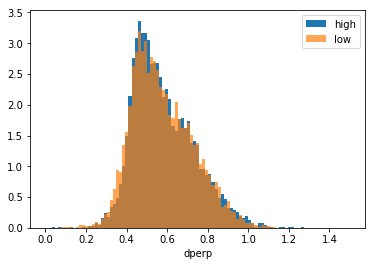

In [409]:
fig, ax = plt.subplots()
mbins = np.linspace(0, 1.5, 100)
ax.hist( dperp_high, bins = mbins, normed = 1, label='high' )
ax.hist( dperp_low, bins = mbins, normed = 1 , alpha = 0.7, label='low')
ax.set_xlabel('dperp')
ax.legend()
fig.savefig(figoutdir + 'dperp_distribution.png')
0

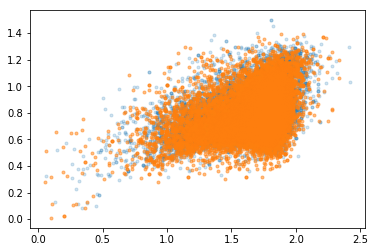

In [513]:
fig, ax = plt.subplots()


#ax.plot( dmass_gelow['MAG_DETMODEL_G'] -dmass_gelow['MAG_DETMODEL_R'], dmass_gelow['MAG_DETMODEL_R']- dmass_gelow['MAG_DETMODEL_I'], '.', alpha = 0.2 )

ax.plot( dmass_gehigh['MAG_DETMODEL_G'] -dmass_gehigh['MAG_DETMODEL_R'], dmass_gehigh['MAG_DETMODEL_R']- dmass_gehigh['MAG_DETMODEL_I'], '.', alpha = 0.2 )
ax.plot( dmass_gelow['MAG_DETMODEL_G'] -dmass_gelow['MAG_DETMODEL_R'], dmass_gelow['MAG_DETMODEL_R']- dmass_gelow['MAG_DETMODEL_I'], '.', alpha = 0.5 )





# Galaxy Bias difference 

In [534]:
help(angular_correlation)

Help on function angular_correlation in module systematics_module.corr:

angular_correlation(data=None, rand=None, njack=30, nbins=20, min_sep=0.041666666666666664, max_sep=4.166666666666667, weight=None, mpi=True, suffix='', out=None, dir='./')



In [540]:
angular_correlation(data = cmass, rand = rand2_cmass, nbins=20, njack = 100, weight=[True, True],
                    suffix = '_cmass_nbins20_jk100', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [14  6 13 10 14  9  7  9 11 10  2  5 13 11 11  4  8  9  6 21 10 11 16 13
  9  6 12  4 13  4 16 13 15 24 14 24 10  9  7 13  6 17  6  6  5  6  5  6
 13  9  9 10  7  6  9  8 15 10  4 18 12 17  5 16 16  8  7  4 13  5  6  7
 11  6 16  7  5 13 14  8  8  8 16 17  7  4  8 15  5 10  3  1 22  4 11 19
 18  6  2  9]
X (11368, 2)  centers (100, 2)  tol=1e-05  maxiter=200
42 iterations  cluster sizes: [124 139 133 120 139 137  91  91 152  93 102  80  78 119 162 105 134 126
 117 189 140  84 113  83  86 112 140 106  68  63 169  92 154 122 121 148
  60 112  60 136  85 130  91 114 106  95  75  76 135  68 123 137 124  93
  84  88 125 191  52 134 119 120  83 165 153 116 123  99 106 114  81 107
 126 113 135 109  97 128 116 125  89  95 108 182  94  81 113 146  73 129
  78 113 192  91  78 128 164  97 103 153]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [551]:
angular_correlation(data = dmass_st82, rand = rand2_cmass, nbins=20, njack = 100, 
                    suffix = '_dmass_st82_nbins20_jk100', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
10 iterations  cluster sizes: [ 4 20 11 11 17  5 12  8 12  6 10  8  7  4  2  9 14  7  6  4  7 16 16  8
  3  7  4  3 10 13  5 14 10  6 11 10  5  4  4  9 16 13 12  9 12 11 13 10
 10 20  7  8  6 13 14  6 10 20 13 17 10  9 17  9  8 18 20 16  4 10  7  7
  8  4 19 12 14  9  9 13 10  9  9 15  8  7  0  9 10  6 15  4 30 12 15  7
  5  6  5 13]
X (11593, 2)  centers (100, 2)  tol=1e-05  maxiter=200
36 iterations  cluster sizes: [ 61 152 182  88 168  94 118  95 114  55 108 119  61 114  68  73  89  84
 112  86 104 167 122 123  87 135 148  90 116 108  78  85 132 136 134 161
 104  68  83 124 150 125 157 119 160 135 170 136 106 119 107  91 122  80
 100  93 115 195 136 160 107 130 147 137  74 133 127 151 116  82  46  64
  68  76 186  95 126  94 115 162 100 131 179 137 114  78  77  84 164  73
 112  87 197 111 248  84  81  83 133 162]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [514]:
#tree corr
from systematics_module.corr import angular_correlation
os.system('mkdir '+basedir)

angular_correlation(data = dmass_gehigh, rand = rand_gehigh, nbins=20, njack = 100, 
                    suffix = '_dmass_gehigh_nbins20_jk100', dir = basedir)
angular_correlation(data = dmass_gelow, rand = rand_gelow, nbins=20, njack = 100, 
                    suffix = '_dmass_gelow_nbins20_jk100', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [11  9  8  9 13 10 12 18 11 16 16 15  7  8 10  6 14 14 14 22 10 13  6 11
 11 17  3 11  8 11 15  8 15 16 10  4  6  5 10 12 10  7  8  5  6 12  6  7
 13  7  6  6  7 10  0  9 13 14 12 16 15  4  9 21 11 13  8  7 10  4  7 15
  9 12 10  9 13  2 11  6  9 17  8  7 13  7 10  7  4  6 16 21 10  1 10  9
  8 11  6  5]
X (19040, 2)  centers (100, 2)  tol=1e-05  maxiter=200
35 iterations  cluster sizes: [181 183  59 203 252 198 305 261 214 206 297 211 296 182 268 207 210 175
 296 239 239 186  95 201 179 256 194 199 222 295 199 172 240 288 220 201
 157 211 193 253 209 140 119 154  94 188 190 153 167 193 205  95 185 230
 111 163 175 165  98 218 201 139 242 231 217 241 104 243 184  66 212 133
 168 254 192 192 223 109 234  54 240 216 227 107 203 204 200 142 115 129
 259 277 125   1 172 185 191 229 157 127]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

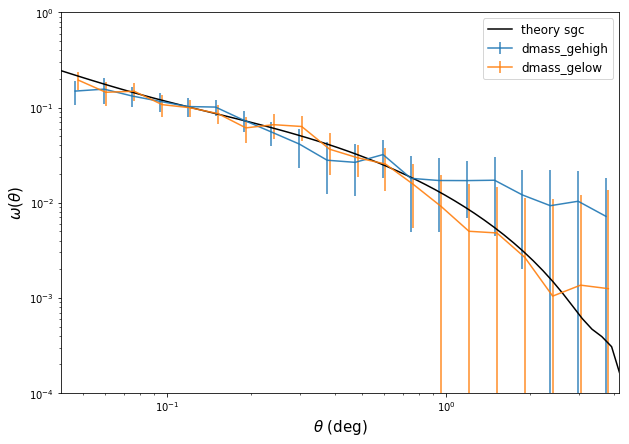

In [608]:

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)

#theory_interp = scipy.interpolate.interp1d(theta_th, theory)
#theory_interp = theory_interp(meanr)
#theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
#theory_sgc_interp = theory_sgc_interp(meanr)

fig, ax = plt.subplots(figsize = (10, 7))
for i, name in enumerate(['dmass_gehigh', 'dmass_gelow']):
    
    filename = basedir+ 'acf_auto_'+name+'_nbins20_jk100.txt'
    covname = basedir+ 'acf_auto_'+name+'_nbins20_jk100.cov'
    meanrw, xiw, xi_errw = np.loadtxt( filename, unpack=True)
    cov_dmass_w = np.loadtxt( covname, unpack=True)
    HFd = 1.0 #HF(50, 20)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    #err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp(meanrw), F_d, verbose=True)
    ax.errorbar(meanrw*(1+0.02*i), xiw, yerr = xi_errw, fmt = '-', alpha=0.9, label=name )
    
ax.plot(theta_th, theory_sgc, '-', color='k', label='theory sgc')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)

In [523]:
def mask_scalecuts( meanrw, rmin = 0.0):
    scalecut = np.zeros(meanrw.size, dtype=bool)
    mask = (meanrw * 60 > rmin)
    scalecut[mask] = 1

    mx, my = np.mgrid[:scalecut.size, :scalecut.size ]
    scalecut2d = scalecut[mx] * scalecut[my]

    n_remain = np.sum(scalecut)
    print n_remain
    return scalecut, scalecut2d

20
err db, db / br1, brmin, br2 : 0.11613389683939557 0.008309596900232696 0.9444248978492337 1.004172132821095 1.0605587946886292
20
err db, db / br1, brmin, br2 : 0.1314407519435029 -0.033510314421460574 0.9156023512055366 0.9835209518320077 1.0470431031490395
20
err db, db / br1, brmin, br2 : 0.07141296398776831 0.01460147932032374 0.9710347994363246 1.0073544324568777 1.042447763424093
20
err db, db / br1, brmin, br2 : 0.07810670473651526 0.03144880725706978 0.9761713897243779 1.0159756105774673 1.0542780944608932
pic save to  ../data_txt/systematics/ge_low//figure/bias_weight.png


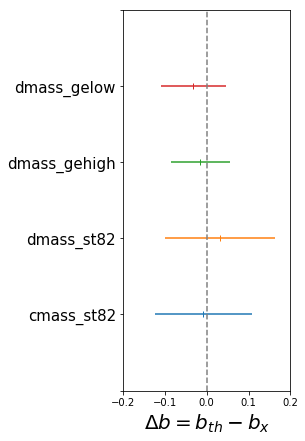

In [559]:
import scipy
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
#theory_sgc_interp = theory_sgc_interp(meanr)

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.5, 1.5, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)
HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
mock_num = 3

j = 1
catlist = ['cmass_st82', 'dmass_st82', 'dmass_gehigh', 'dmass_gelow']
for name in catlist:
    
    filename = basedir+ 'acf_auto_'+name+'_nbins20_jk100.txt'
    covname = basedir+ 'acf_auto_'+name+'_nbins20_jk100.cov'
    scalecut, scalecut2d = mask_scalecuts( meanrw)
    theory_interp = theory_sgc_interp(meanrw)
    cov_dmass_w = np.loadtxt( covname, unpack=True)
    HFd = 1.0 #HF(100, n_remain)
    F_d = HFd * np.linalg.inv(cov_dmass_w[scalecut2d].reshape(n_remain,n_remain))
    #print xiw.shape, theory_interp.shape
    #print xiw[scalecut].shape, theory_interp[scalecut].shape, F_d.shape
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw[scalecut], theory_interp[scalecut], F_d, verbose=True)   
    #ax.errorbar(2.-2*brelw, mock_num+1-j, xerr =err_brelw*2., fmt='-|', color='k')
    ax.errorbar(2-2*brelw, j, xerr =err_brelw*2., fmt='-|', label = name)
    j += 1
#ax.axvspan(- err_brelw*2, err_brelw*2.,  alpha=0.1, color='grey')
#ax.axvspan(- err_brelw*2, err_brelw*2.,  alpha=0.1, color='grey')
ax.axvline(x=0.0, color = 'grey', ls='--')
 
ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
#ax.legend(loc=1)
ax.set_xlim(-0.2, 0.2)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(len(catlist) + 2))
ax.set_yticklabels( [''] + catlist, fontsize = 15) 
fig.savefig(figoutdir + 'bias_weight.png')
print 'pic save to ', figoutdir + 'bias_weight.png'